# Imports

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns

import re
import pickle
from unidecode import unidecode
import category_encoders as ce
import requests

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from joypy import joyplot

from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn.impute import KNNImputer
from boruta import BorutaPy
from sklearn import linear_model as lm
import xgboost

import warnings
warnings.filterwarnings("ignore")

## Functions

In [1]:
def extract_power(re_string):
    hp = 'sem informação'
    if re_string is None:
        pass
    else:
         hp = re_string.group(0)
    return hp

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y,yhat)
    mape = mt.mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mt.mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

def train_preparation(x_train_prep, y_train_prep):
    # transforma response variable
    y_train_prep = pd.DataFrame(np.log1p(y_train_prep))

    # standarization
    sc = pp.StandardScaler()
    y_train_norm_prep = sc.fit_transform(y_train_prep)
    pickle.dump(sc, open('api/parameters/sc_response.pkl','wb'))
    
    sc = pp.StandardScaler()
    x_train_prep['km_media_ano_em_1k_km'] = sc.fit_transform(x_train_prep[['km_media_ano_em_1k_km']])
    pickle.dump(sc, open('api/parameters/sc_km_media_ano.pkl','wb'))

    # rescaling
    rs = pp.RobustScaler()

    x_train_prep['ano_de_fabricacao'] = rs.fit_transform(x_train_prep[['ano_de_fabricacao']])
    pickle.dump(rs, open('api/parameters/rs_ano_de_fabricacao.pkl','wb'))

    x_train_prep['ano_modelo'] = rs.fit_transform(x_train_prep[['ano_modelo']])
    pickle.dump(rs, open('api/parameters/rs_ano_modelo.pkl','wb'))

    x_train_prep['odometro'] = rs.fit_transform(x_train_prep[['odometro']])
    pickle.dump(rs, open('api/parameters/rs_odometro.pkl','wb'))

    # encodings
    ## one hot encode

    # blindado
    x_train_prep['blindado'] = x_train_prep['blindado'].replace({'S':1, 'N':0})

    # tipo_vendedor
    x_train_prep['tipo_vendedor'] = x_train_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

    # tipo_anuncio
    oe = pp.OneHotEncoder(sparse=False,handle_unknown='ignore')
    x_train_prep['tipo_anuncio'] = x_train_prep['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
    cols_dummies = oe.fit_transform(x_train_prep['tipo_anuncio'].values.reshape(-1,1))
    x_train_prep[oe.categories_[0]] = cols_dummies
    pickle.dump(oe,open(f'api/parameters/oe_tipo_anuncio.pkl', 'wb'))

    x_train_prep['cambio'] = x_train_prep['cambio'].map({'Manual':0,
                                                'Automática Sequencial':1, 
                                                'Semi-automática':2,
                                                'CVT':3,
                                                'Automatizada':4,
                                                'Automática':4,
                                                'Automatizada DCT':5
                                                })

    x_train_prep['num_portas'] = x_train_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

    # target encode
    for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
        te = ce.TargetEncoder(cols=[att],handle_unknown='return_nan').fit(x_train_prep, y_train_norm_prep)
        pickle.dump(te, open(f'api/parameters/te_{att}.pkl','wb'))
        x_train_prep = te.transform(x_train_prep)

    # frequency encode
    for att in ['marca', 'modelo','versao','cilindradas']:
        fe =  ce.CountEncoder(cols=[att],handle_unknown='return_nan', normalize=True).fit(x_train_prep)
        pickle.dump(fe,open(f'api/parameters/fe_{att}.pkl', 'wb'))
        x_train_prep = fe.transform(x_train_prep)

    return x_train_prep, y_train_prep

def test_preparation(x_test_prep, y_test_prep):
   
    # Transformando variável resposta
    y_test_prep = pd.DataFrame(np.log1p(y_test_prep))
    
    # Standarization
    sc = pickle.load(open('api/parameters/sc_km_media_ano.pkl','rb'))
    x_test_prep['km_media_ano_em_1k_km'] = sc.transform(x_test_prep[['km_media_ano_em_1k_km']])

    # Rescaling
    rs = pickle.load(open('api/parameters/rs_ano_de_fabricacao.pkl','rb'))
    x_test_prep['ano_de_fabricacao'] = rs.transform(x_test_prep[['ano_de_fabricacao']])

    rs = pickle.load(open('api/parameters/rs_ano_modelo.pkl','rb'))
    x_test_prep['ano_modelo'] = rs.transform(x_test_prep[['ano_modelo']])

    rs = pickle.load(open('api/parameters/rs_odometro.pkl','rb'))
    x_test_prep['odometro'] = rs.transform(x_test_prep[['odometro']])

    # Encode
    ## One Hot Encode
    # blindado
    x_test_prep['blindado'] = x_test_prep['blindado'].replace({'S':1, 'N':0})

    # tipo_vendedor
    x_test_prep['tipo_vendedor'] = x_test_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

    # tipo_anuncio
    oe = pickle.load(open(f'api/parameters/oe_tipo_anuncio.pkl', 'rb'))
    x_test_prep['tipo_anuncio'] = x_test_prep['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
    cols_dummies = oe.transform(x_test_prep['tipo_anuncio'].values.reshape(-1,1))
    x_test_prep[oe.categories_[0]] = cols_dummies

    x_test_prep['cambio'] = x_test_prep['cambio'].map({'Manual':0,
                                                'Automática Sequencial':1, 
                                                'Semi-automática':2,
                                                'CVT':3,
                                                'Automatizada':4,
                                                'Automática':4,
                                                'Automatizada DCT':5
                                                })

    x_test_prep['num_portas'] = x_test_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

    ## Target Encode
    for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
        te = pickle.load(open(f'api/parameters/te_{att}.pkl','rb'))
        x_test_prep = te.transform(x_test_prep)

    ## Frequency Encode

    for att in ['marca', 'modelo','versao','cilindradas']:
        fe = pickle.load(open(f'api/parameters/fe_{att}.pkl', 'rb'))
        x_test_prep = fe.transform(x_test_prep)
        
    ## KNN Imputer
    ## Preenche valores de target e frequency encode não encontratos
    imputer = KNNImputer(n_neighbors=5, copy=True)
    original_index = X_test.index
    x_test_prep = pd.DataFrame(imputer.fit_transform(x_test_prep.drop(['cidade_vendedor','estado_vendedor','tipo_anuncio'],axis=1)),columns = x_test_prep.drop(['cidade_vendedor','estado_vendedor','tipo_anuncio'],axis=1).columns)
    x_test_prep = original_index    
    return x_test_prep, y_test_prep

def cross_validation_k_fold(X_cross, y_cross, features_selected, model_name, model, k):

    cv_results = pd.DataFrame()
    
    k_fold = ms.KFold(n_splits=k)
    
    X_cross = feature_engineering(X_cross)
    
    cols_drop = [
         'ID',
         'num_fotos',
         'attr_veiculo_aceita_troca',
         'attr_veiculo_único_dono',
         'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
         'attr_veiculo_ipva_pago',
         'attr_veiculo_licenciado',
         'attr_veiculo_garantia_de_fábrica',
         'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
         'attr_veiculo_alienado']

    X_cross = X_cross.drop(columns=cols_drop)

    ## Para cada k_fold
    for i, (train_index, test_index) in enumerate(k_fold.split(X_cross)):

        # Separar treino e teste
        X_train_cross, y_train_cross = X_cross.loc[train_index], y_cross.iloc[train_index]

        X_test_cross, y_test_cross = X_cross.loc[test_index], y_cross.iloc[test_index]

        ## Data Preparation
        # Transformar treino
        X_train_cross, y_train_cross = train_preparation(X_train_cross, y_train_cross)

        # Transformar teste
        X_test_cross, y_test_cross = test_preparation(X_test_cross, y_test_cross)

        ## Treinar modelo
        model.fit(X_train_cross[features_selected], y_train_cross)

        ## Predict
        y_pred_cross = model.predict(X_test_cross[features_selected])

        ## Performance
        result_model = ml_error(model_name, np.expm1(y_test_cross), np.expm1(y_pred_cross))

        ## Salvar resultado
        cv_results = pd.concat([cv_results, result_model.drop('Model Name', axis=1)], axis=0)
        
    cv_values = round(cv_results.mean(),3)
    cv_std = round(cv_results.std(),3)
    return pd.DataFrame({'Model': model_name,
                 'MAE': cv_values['MAE'].astype(str) + ' +/- ' + cv_std['MAE'].astype(str),
                 'MAPE': cv_values['MAPE'].astype(str) + ' +/- ' + cv_std['MAPE'].astype(str),
                 'RMSE': cv_values['RMSE'].astype(str) + ' +/- ' + cv_std['RMSE'].astype(str)}, index=[0])

def feature_engineering(df4):
    
    df_feature_engineering = df4.copy()
    # extraindo as cilindradas da coluna versão
    df_feature_engineering['cilindradas'] = df_feature_engineering['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

    # extraindo válvulas da coluna versão
    df_feature_engineering['valvulas'] = df_feature_engineering['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

    # extraindo combustível da coluna versão
    df_feature_engineering['combustivel'] = df_feature_engineering['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                       'FLEX' if 'FLEX'     in x else 
                                                       'DIESEL' if 'DIESEL'   in x else 
                                                       'ÁLCOOL' if 'ÁLCOOL' in x else
                                                       'HÍBRIDO' if 'HYBRID' in x else
                                                       'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

    # removendo features derivadas da coluna original
    df_feature_engineering['versao'] = df_feature_engineering.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

    # retirando acentos, substituindo letras maiúsculas e espaços
    df_feature_engineering['cidade_vendedor'] = df_feature_engineering['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

    # extraindo estado
    df_feature_engineering['estado_vendedor'] = df_feature_engineering['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

    # criando feature de localidade
    df_feature_engineering['localidade_vendedor'] = df_feature_engineering['cidade_vendedor'] + "_" + df_feature_engineering['estado_vendedor']

    # criando feature de km médio rodado por ano
    df_feature_engineering['km_media_ano_em_1k_km'] = df_feature_engineering['odometro']/np.round(2023 - df_feature_engineering['ano_modelo'] + 0.51,0)
    # arredondando e escalando por 1000 km
    df_feature_engineering['km_media_ano_em_1k_km'] = round(df_feature_engineering['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

    # criando feature de agregação do veículo com marca, modelo, km_media e localidade
    df_feature_engineering['veiculo'] = df_feature_engineering['marca'].astype(str) + "_" + df_feature_engineering['modelo'].astype(str)# + "_" + df_feature_engineering['km_media_ano_em_1k_km'].astype(str)
    
    return df_feature_engineering

# Load Dataset

In [107]:
df_raw = pd.read_csv('datasets/treino.csv')

In [108]:
df_raw.shape

(39446, 29)

In [109]:
X = df_raw.drop(columns=['preco'])
y = df_raw['preco']

## Split Dataset

In [110]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = ms.train_test_split(X, y, test_size=0.2, random_state=0)

data_train = pd.concat([X_train_raw,y_train_raw], axis=1)
data_test = pd.concat([X_test_raw,y_test_raw], axis=1)

In [111]:
print(f'Treino: {data_train.shape[0]}')
print(f'Test: {data_test.shape[0]}')

Treino: 31556
Test: 7890


In [112]:
df = data_train.copy()

# Data Description

In [113]:
df.columns.tolist()

['ID',
 'num_fotos',
 'marca',
 'modelo',
 'versao',
 'ano_de_fabricacao',
 'ano_modelo',
 'odometro',
 'cambio',
 'num_portas',
 'tipo',
 'blindado',
 'cor',
 'tipo_vendedor',
 'cidade_vendedor',
 'estado_vendedor',
 'tipo_anuncio',
 'entrega_delivery',
 'troca',
 'elegivel_revisao',
 'attr_veiculo_aceita_troca',
 'attr_veiculo_único_dono',
 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
 'attr_veiculo_ipva_pago',
 'attr_veiculo_licenciado',
 'attr_veiculo_garantia_de_fábrica',
 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
 'attr_veiculo_alienado',
 'preco']

## Data Dimension

In [114]:
print(f'Número de linhas: {df.shape[0]}')
print(f'Número de colunas: {df.shape[1]}')

Número de linhas: 31556
Número de colunas: 29


## Data Types

In [115]:
df.dtypes

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Check NAs

In [116]:
df.isna().sum()

ID                                                                0
num_fotos                                                       188
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

## Filtering Data

In [117]:
# removendo colunas que possuem NA's + id
 
cols_drop = [
 'ID',
 'num_fotos',
 'attr_veiculo_aceita_troca',
 'attr_veiculo_único_dono',
 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
 'attr_veiculo_ipva_pago',
 'attr_veiculo_licenciado',
 'attr_veiculo_garantia_de_fábrica',
 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
 'attr_veiculo_alienado']

df = df.drop(columns=cols_drop)

## Descriptive Statistical

Objetivos: 
1. Ganhar conhecimento de negócio 
2. Detectar erros nos dados


### Numerical Attributes

In [118]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [119]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.751331,2018.000000,4.088403,-2.511113,9.262741
1,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.811351,2018.000000,2.676889,-0.504198,-0.513283
2,odometro,100.000000,3.817280e+05,3.816280e+05,58330.343009,57180.000000,32483.482401,0.579675,1.034479
3,num_portas,2.000000,4.000000e+00,2.000000e+00,3.940170,4.000000,0.339775,-5.519150,28.510117
4,preco,7258.159943,1.352089e+06,1.344831e+06,133677.588245,114620.767775,82725.230480,2.262564,12.754476


### Categorical Attributes

- "entrega_delivery", "troca" e "elegivel_revisao" parecem ser variáveis com baixo poder preditivo pois sua distribuição em relação ao preção é bem parecida para cada uma de suas labels

In [120]:
for col in cat_attributes.columns.tolist():
    elements = df[col].unique().tolist()
    n_elements = len(elements)
    
    print(f'{col}: {n_elements}')

marca: 41
modelo: 466
versao: 1945
cambio: 7
tipo: 8
blindado: 2
cor: 7
tipo_vendedor: 2
cidade_vendedor: 593
estado_vendedor: 25
tipo_anuncio: 4
entrega_delivery: 2
troca: 2
elegivel_revisao: 1


#### Marca

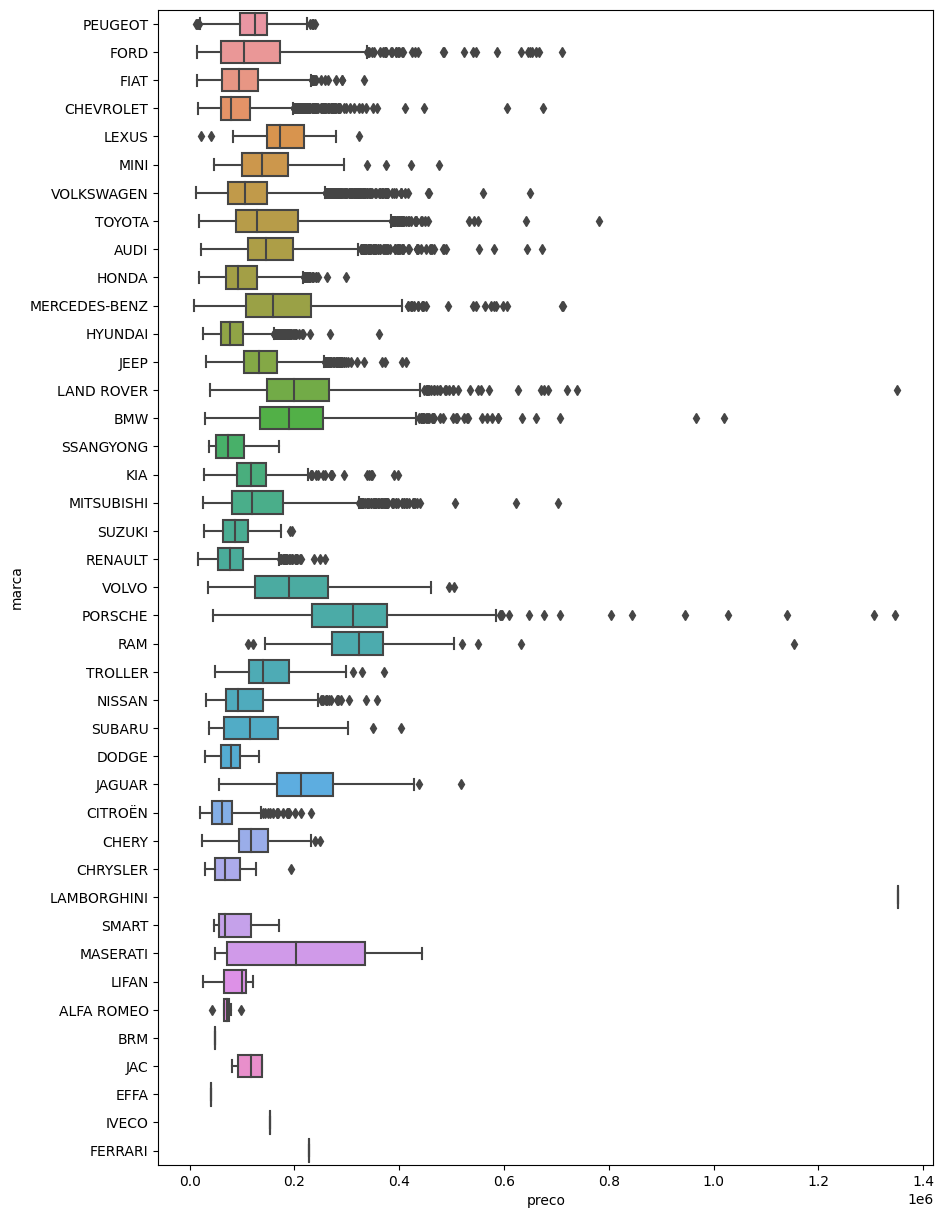

In [121]:
plt.figure(figsize=(10,15))
sns.boxplot(x='preco' , y='marca' , data=df);

#### Cambio

<Axes: xlabel='cambio', ylabel='preco'>

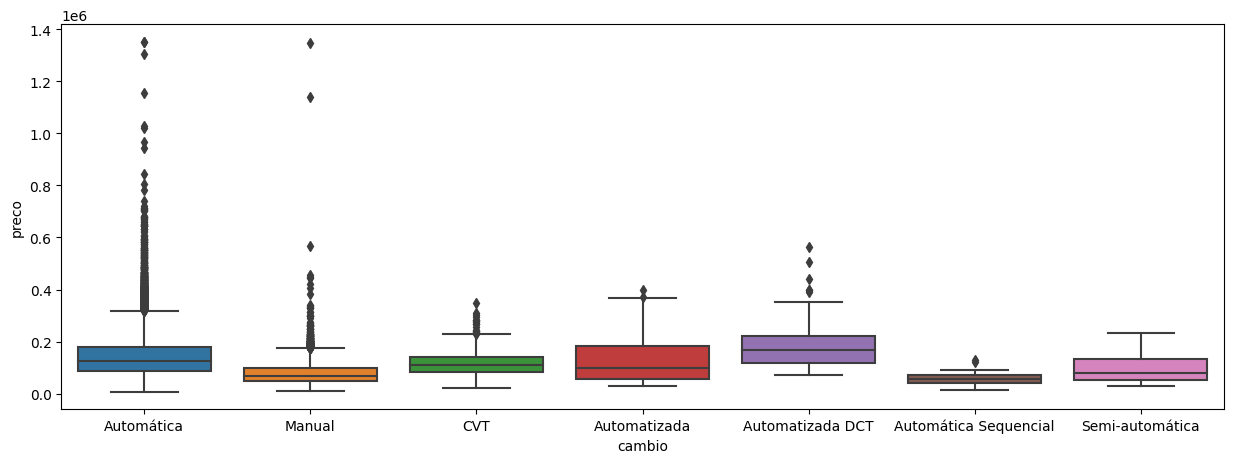

In [122]:
plt.figure(figsize=(15,5))
sns.boxplot(x='cambio' , y='preco' , data=df)

#### Tipo

<Axes: xlabel='tipo', ylabel='preco'>

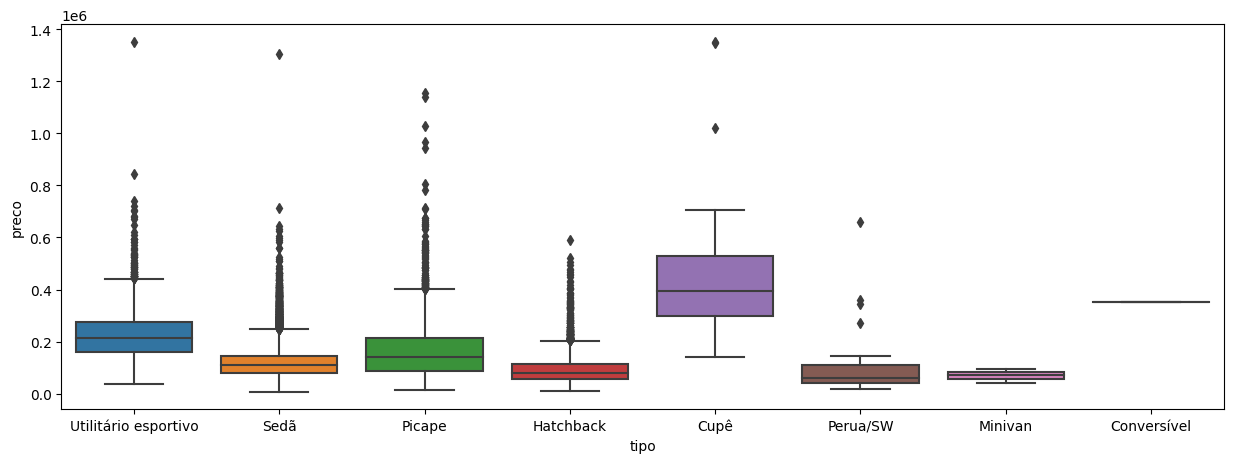

In [123]:
plt.figure(figsize=(15,5))
sns.boxplot(x='tipo' , y='preco' , data=df)

#### Blindado

<Axes: xlabel='blindado', ylabel='preco'>

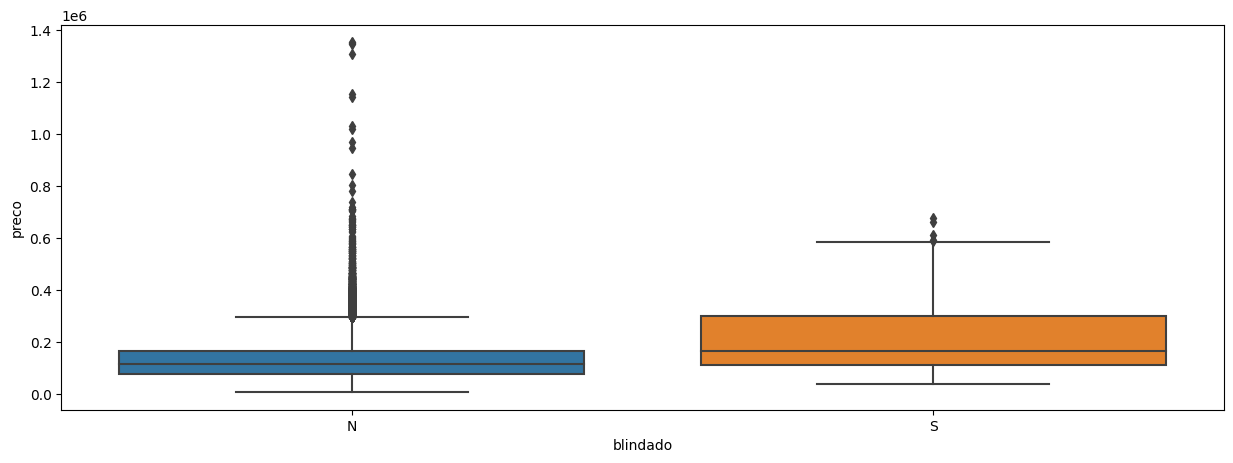

In [124]:
plt.figure(figsize=(15,5))
sns.boxplot(x='blindado' , y='preco' , data=df)

#### Cor

<Axes: xlabel='cor', ylabel='preco'>

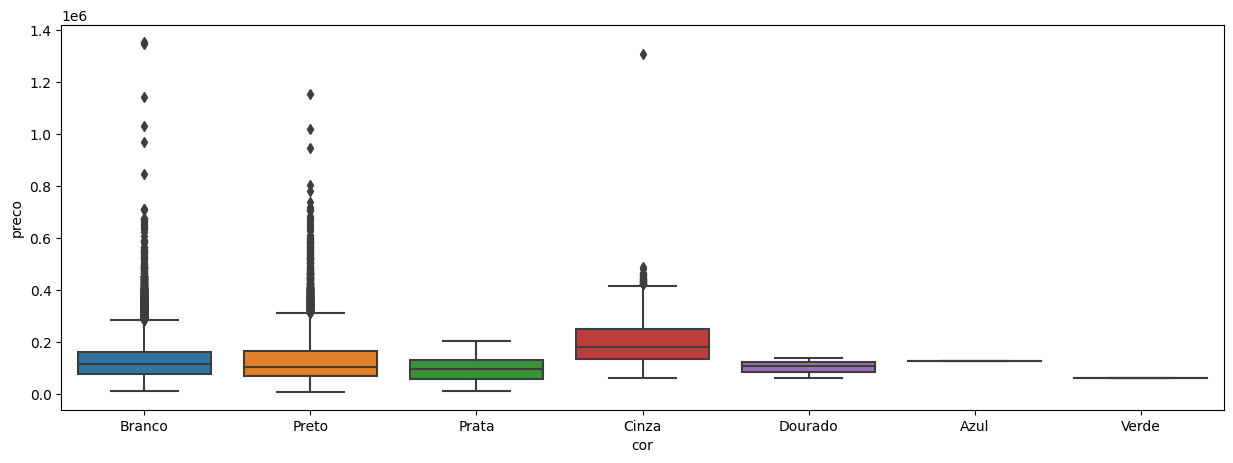

In [125]:
plt.figure(figsize=(15,5))
sns.boxplot(x='cor' , y='preco' , data=df)

#### Tipo Vendedor

<Axes: xlabel='tipo_vendedor', ylabel='preco'>

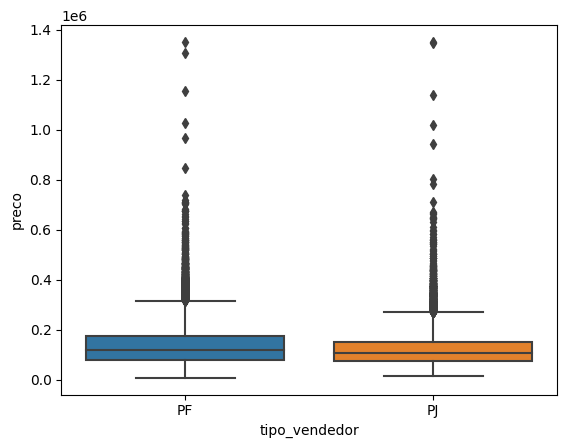

In [126]:
sns.boxplot(x='tipo_vendedor' , y='preco' , data=df)

#### Estado Vendedor

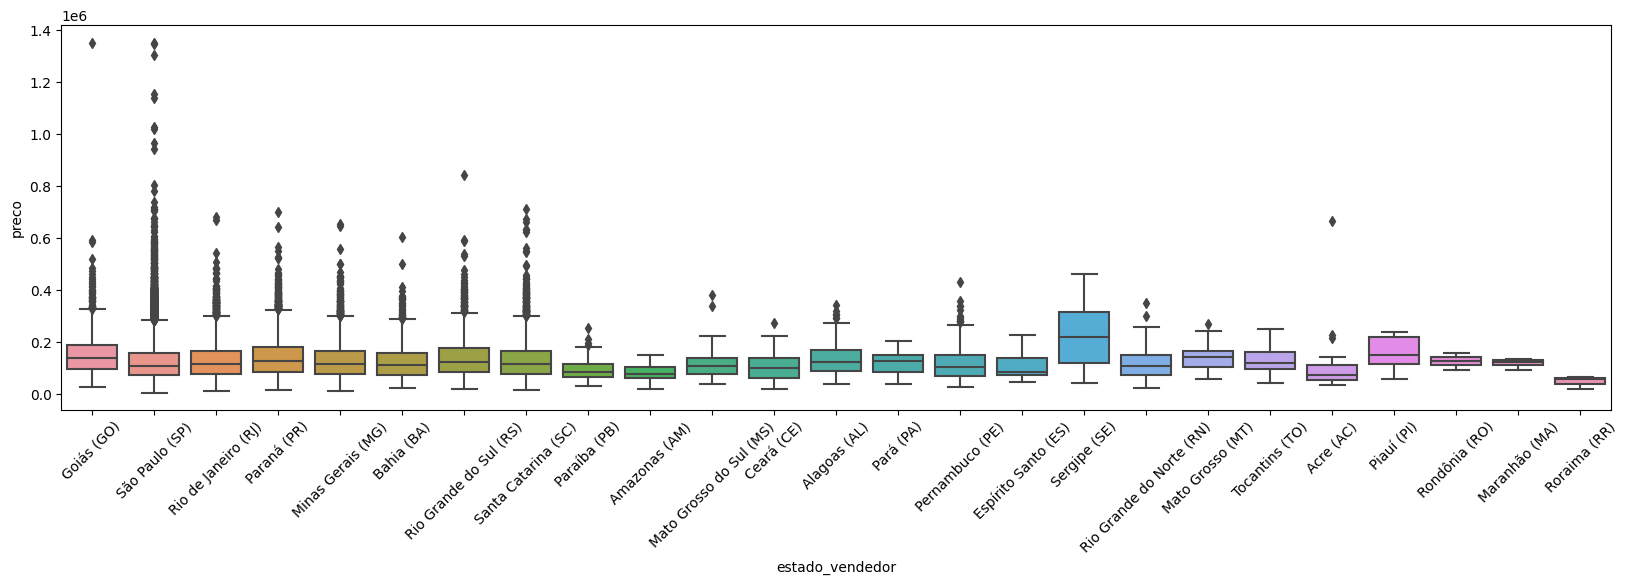

In [127]:
plt.figure(figsize=(20,5))
sns.boxplot(x='estado_vendedor' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Entrega Delivey

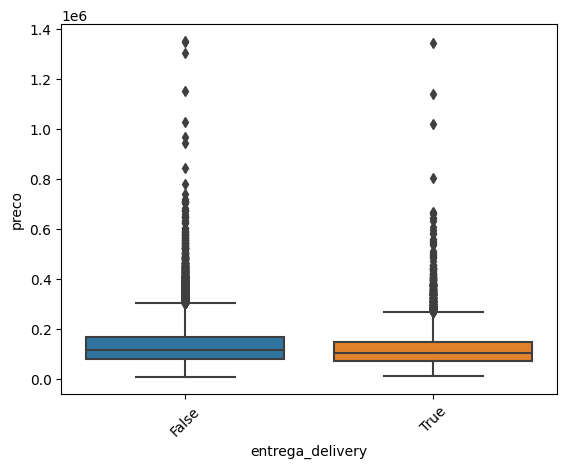

In [128]:
sns.boxplot(x='entrega_delivery' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Troca

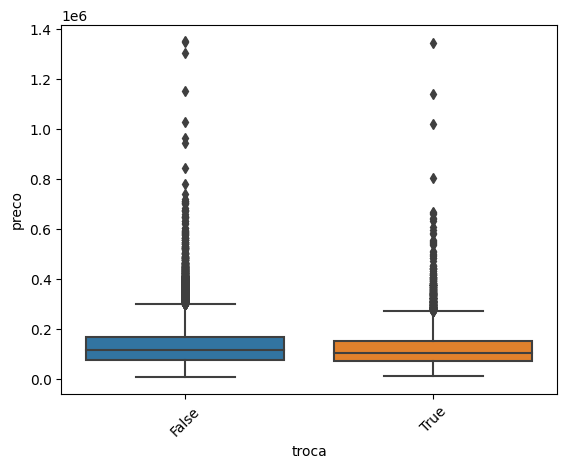

In [129]:
sns.boxplot(x='troca' , y='preco' , data=df)
plt.xticks(rotation=45);

#### Elegível Revisão

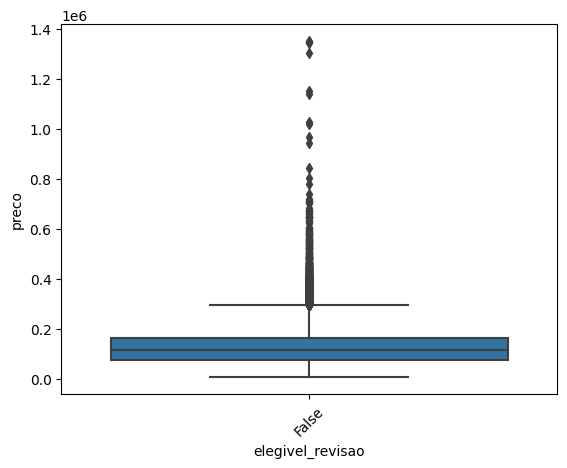

In [130]:
sns.boxplot(x='elegivel_revisao' , y='preco' , data=df)
plt.xticks(rotation=45);

# Feature Engineering

In [131]:
df4 = df.copy()

## Feature Creation

In [132]:
# extraindo as cilindradas da coluna versão
df4['cilindradas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

# extraindo válvulas da coluna versão
df4['valvulas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

# extraindo combustível da coluna versão
df4['combustivel'] = df4['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                   'FLEX' if 'FLEX'     in x else 
                                                   'DIESEL' if 'DIESEL'   in x else 
                                                   'ÁLCOOL' if 'ÁLCOOL' in x else
                                                   'HÍBRIDO' if 'HYBRID' in x else
                                                   'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

# removendo features derivadas da coluna original
df4['versao'] = df4.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

# retirando acentos, substituindo letras maiúsculas e espaços
df4['cidade_vendedor'] = df4['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

# extraindo estado
df4['estado_vendedor'] = df4['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

# criando feature de localidade
df4['localidade_vendedor'] = df4['cidade_vendedor'] + "_" + df4['estado_vendedor']

# criando feature de km médio rodado por ano
df4['km_media_ano_em_1k_km'] = df4['odometro']/np.round(2023 - df4['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
df4['km_media_ano_em_1k_km'] = round(df4['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
df4['veiculo'] = df4['marca'].astype(str) + "_" + df4['modelo'].astype(str) #+ "_" + df4['km_media_ano_em_1k_km'].astype(str)

In [133]:
df4.sample(3)

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,entrega_delivery,troca,elegivel_revisao,preco,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo
33436,BMW,X6,35I 4X4 COUPÉ 6 CILINDROS 4P,2013,2014.0,71212.0,Automática,4,Utilitário esportivo,N,...,False,False,False,180395.535759,3.0,24V,GASOLINA,sao_bernardo_do_campo_SP,7,BMW_X6
2827,MERCEDES-BENZ,GLC 43 AMG,V6 4MATIC 9G-TRONIC,2018,2019.0,18068.0,Automática,4,Sedã,N,...,False,False,False,225829.395703,3.0,sem informação,GASOLINA,rio_de_janeiro_RJ,4,MERCEDES-BENZ_GLC 43 AMG
31991,BMW,320i,SPORT TURBO ACTIVE 4P,2017,2018.0,58290.0,Automática,4,Sedã,N,...,False,False,False,168384.276576,2.0,16V,FLEX,belo_horizonte_MG,10,BMW_320i


# Exploratory Data Analysis

Objetivos:
1. Ganhar experiência de Negócio
2. Validar Hióteses de Negócios
3. Perceber variáveis que são importantes para o modelo
    - Não podemos confiar 100% na seleção de features

In [134]:
df5 = df4.copy()

## Univariate Analysis

### Response Variable

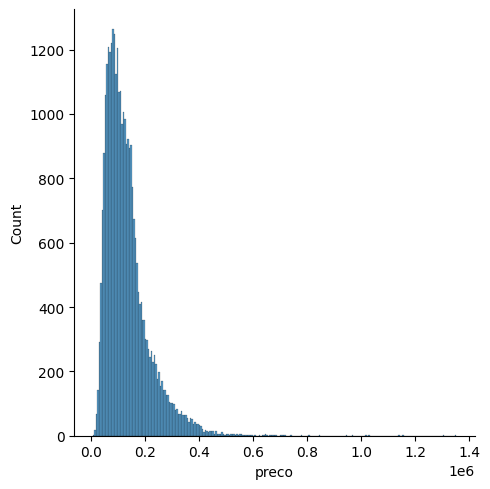

In [135]:
sns.displot(df5['preco'])

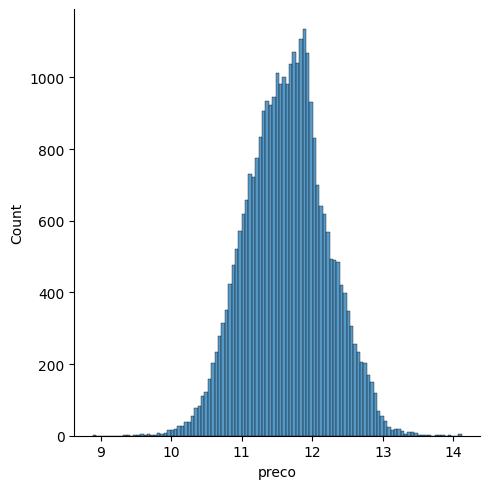

In [136]:
sns.displot(np.log1p(df5['preco']));

### Numerical Variable

**Scalers sugeridos:**

| Atributo               | Rescaling  |
| ---------------------- | ------------- |
|**Ano de Fabricação:** | Robust Scaler |
|**Ano do Modelo:** | Robust Scaler|
|**Odometro:** | Robust Scaler|
|**Número de Portas:** | Ordinal Encode|

In [137]:
num_attributes = df5.select_dtypes(include=['int64','float64'])
cat_attributes = df5.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### Ano de Fabricação

- Não possui distribuição normal e possui muitos outliers
- Rescaling: **ROBUST SCALER**

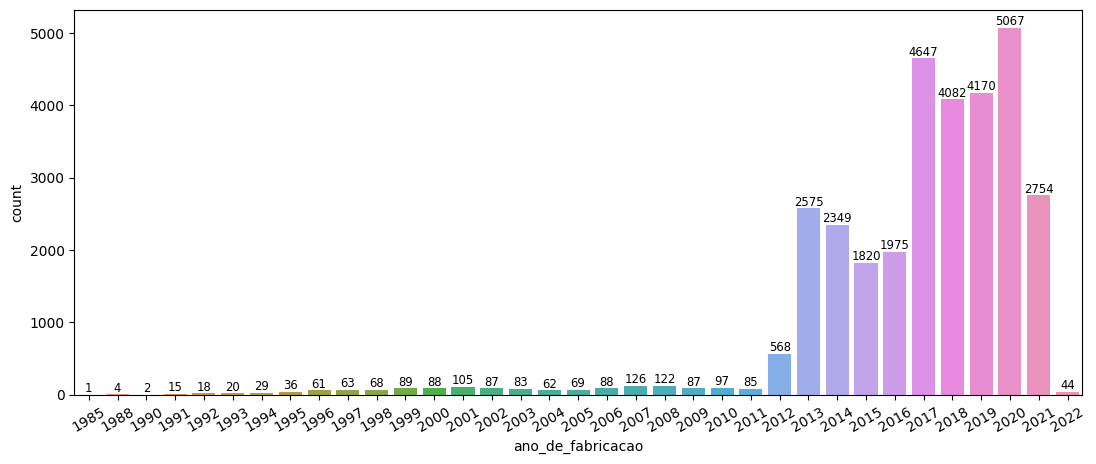

In [138]:
plt.figure(figsize=(13,5))
g = sns.countplot(x='ano_de_fabricacao', data=df5)
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='small',fmt='%.0f')
plt.xticks(rotation=30);

#### Ano do modelo

- Não possui distribuição normal e possui outliers
- Rescaling: **ROBUST SCALER**

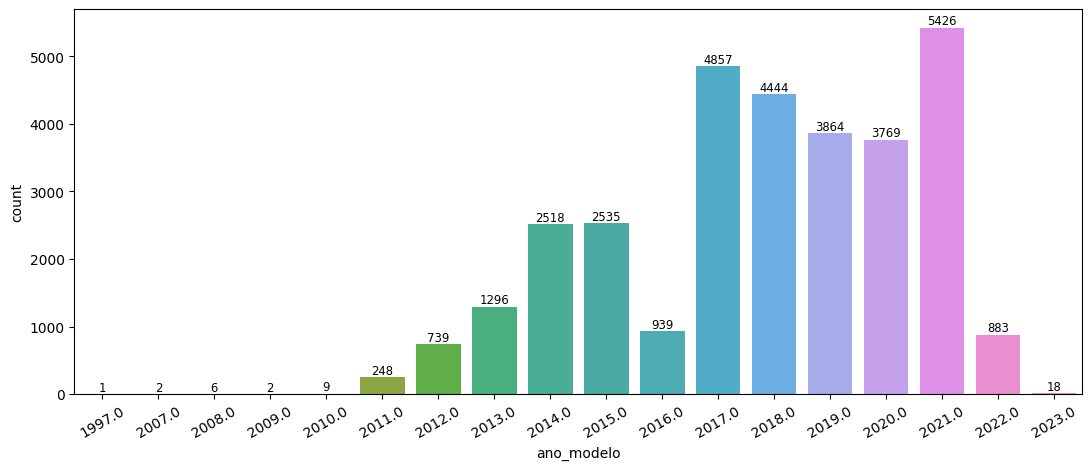

In [139]:
plt.figure(figsize=(13,5))
g = sns.countplot(x='ano_modelo', data=df5)
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='small',fmt='%.0f')
plt.xticks(rotation=30);

#### Odometro

- Não possui distribuição normal e possui outliers
- Rescaling: **ROBUST SCALER**

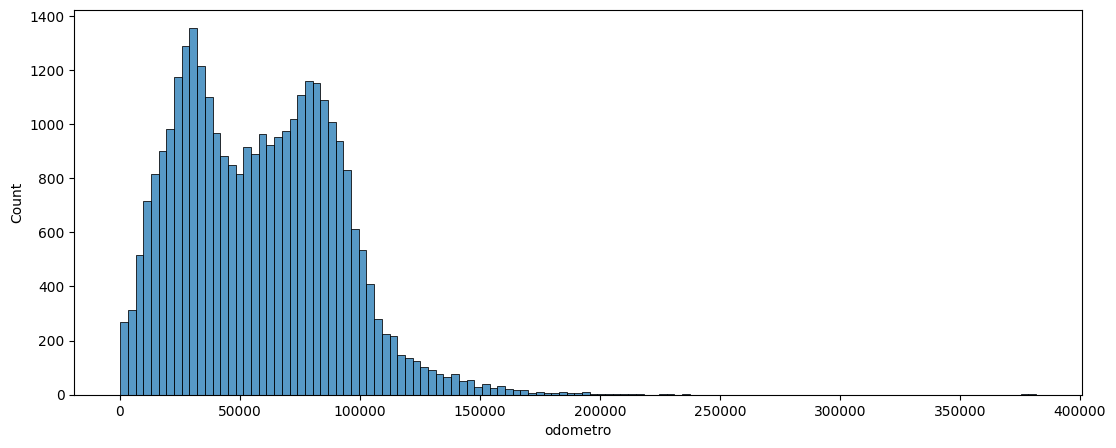

In [140]:
plt.figure(figsize=(13,5))
g = sns.histplot(x='odometro', data=df5)

#### Número de Portas

- Variável numérica com poucos labels
- Transformar em variável categórica e utilizar o **ORDINAL ENCONDING**

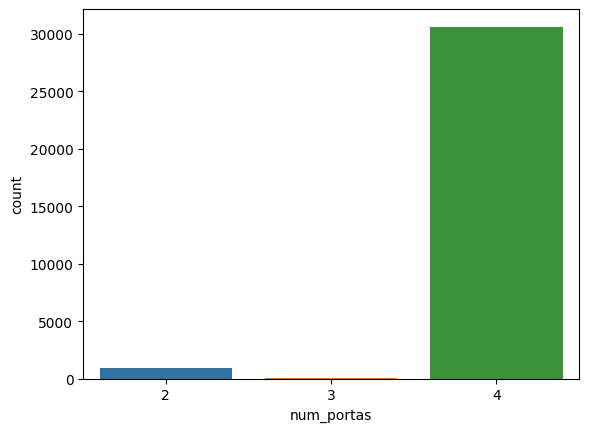

In [141]:
sns.countplot(x='num_portas', data=df5);

### Categorical Variables

####  Marca

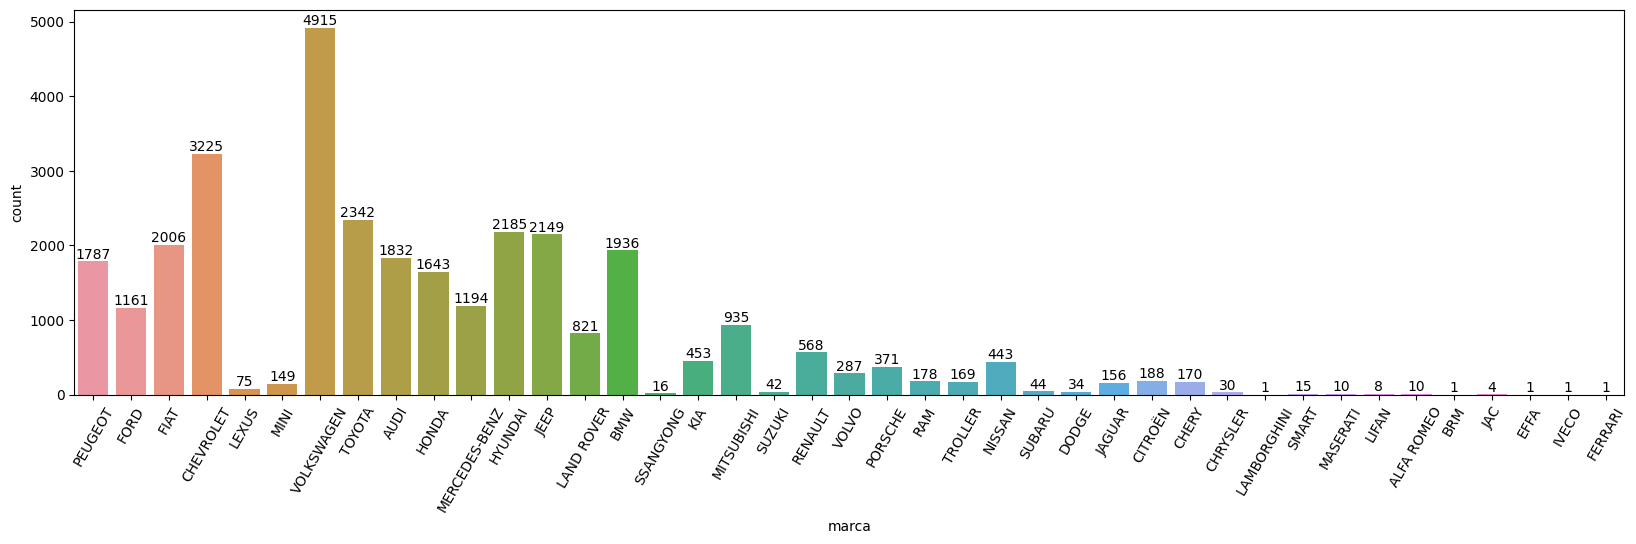

In [142]:
plt.figure(figsize=(20,5))
g = sns.countplot(x = 'marca', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=60);

#### Cambio

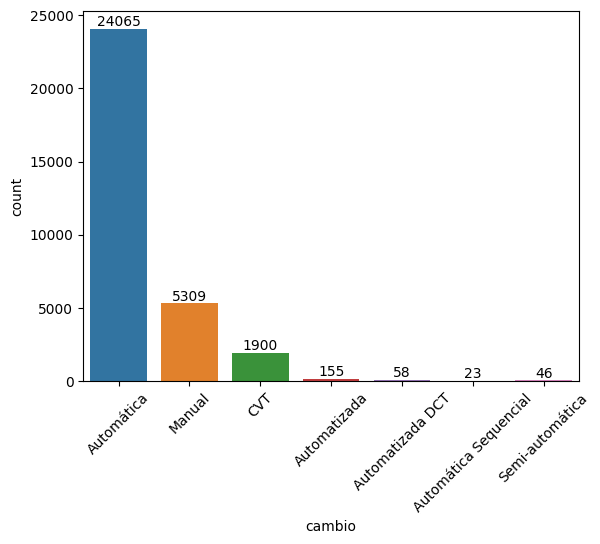

In [143]:
g = sns.countplot(x = 'cambio', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Tipo

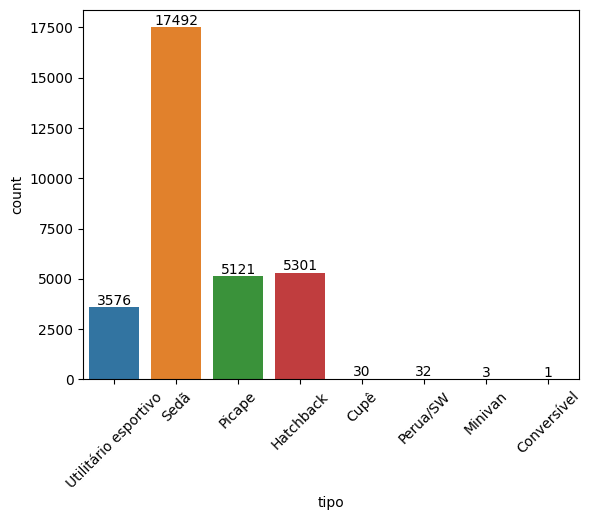

In [144]:
g = sns.countplot(x = 'tipo', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Blindado

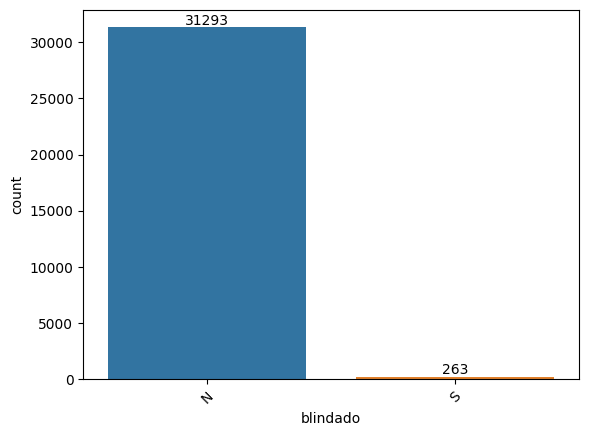

In [145]:
g = sns.countplot(x = 'blindado', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Cor

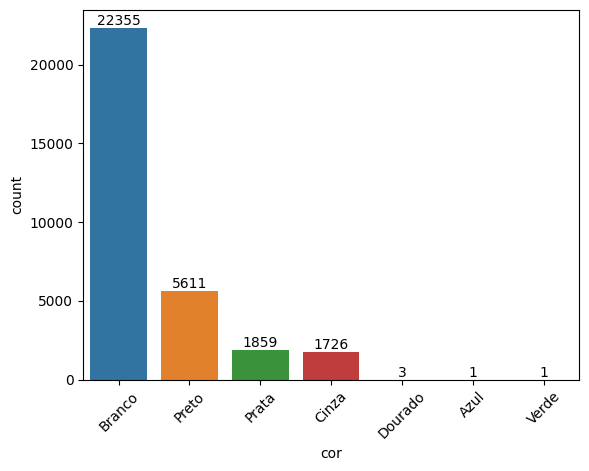

In [146]:
g = sns.countplot(x = 'cor', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Tipo Vendedor

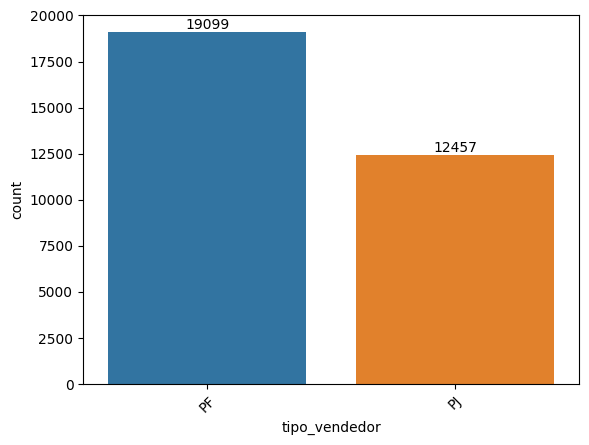

In [147]:
g = sns.countplot(x = 'tipo_vendedor', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Entrega Delivery

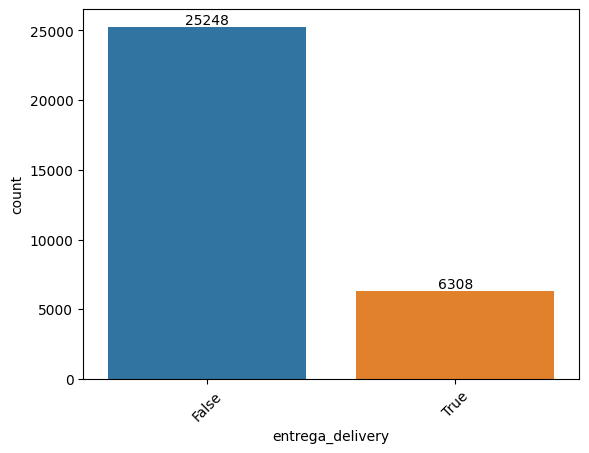

In [148]:
g = sns.countplot(x = 'entrega_delivery', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Troca

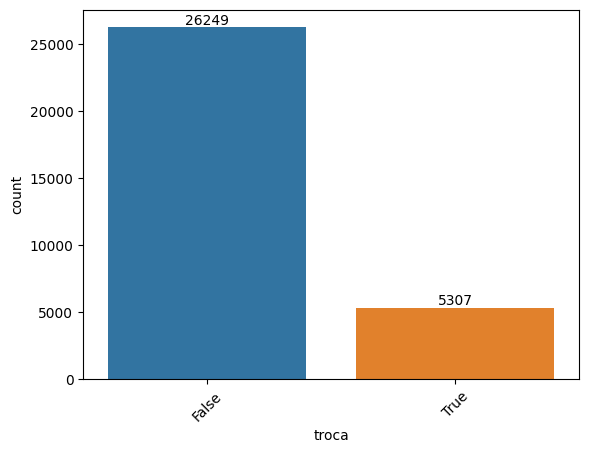

In [149]:
g = sns.countplot(x = 'troca', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

#### Elegível Revisão

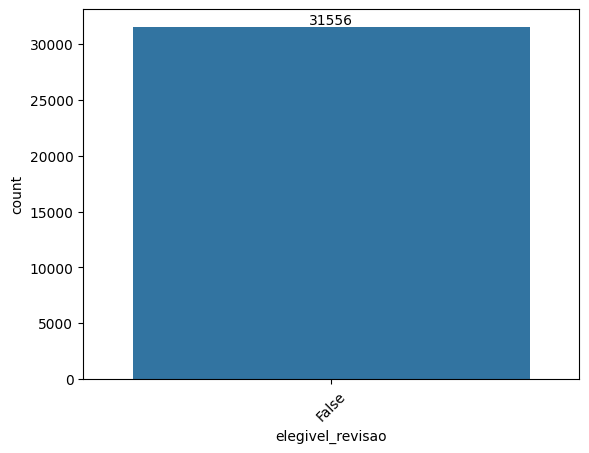

In [150]:
g = sns.countplot(x = 'elegivel_revisao', data=df5);
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize='medium',fmt='%.0f')
plt.xticks(rotation=45);

## Bivariate Analysis

**Encodes sugeridos**

| Atributo                | Encode          |
| ----------------------- | --------------- |
| **Marca:**              | Frequency Encode| 
| **Modelo:**             | Frequency Encode| 
| **Versão:**             | Frequency Encode| 
| **Câmbio:**             | Ordinal Enconde| 
| **Tipo:**               | Target Encode| 
| **Blindado:**           | One Hot Encode| 
| **Cor:**                | Target Encode| 
| **Tipo de Vendedor:**   | One Hot Encode| 
| **Cidade do Vendedor:** | Target Encode| 
| **Tipo de Anúncio:**    | One Hot Encode| 
| **Entrega Delivery:**   | One Hot Encode| 
| **Cilindradas:**        | Frequency Encode| 
| **Válvulas:**           | Target Encode| 
| **Combustível:**        | Target Encode| 


In [151]:
for col in cat_attributes.columns.tolist():
    print( f'{col}: {cat_attributes[col].unique().shape[0]}')

marca: 41
modelo: 466
versao: 1631
cambio: 7
tipo: 8
blindado: 2
cor: 7
tipo_vendedor: 2
cidade_vendedor: 593
estado_vendedor: 25
tipo_anuncio: 4
entrega_delivery: 2
troca: 2
elegivel_revisao: 1
cilindradas: 47
valvulas: 12
combustivel: 6
localidade_vendedor: 1016
km_media_ano_em_1k_km: 39
veiculo: 466


#### Marca

- Variável com muitos labels
- Entende-se que pode ser influenciada pela oferta e demanda, quanto mais carros vendidos de determinada marca, menor o preço
- Enconding: **Frequency Encoding**

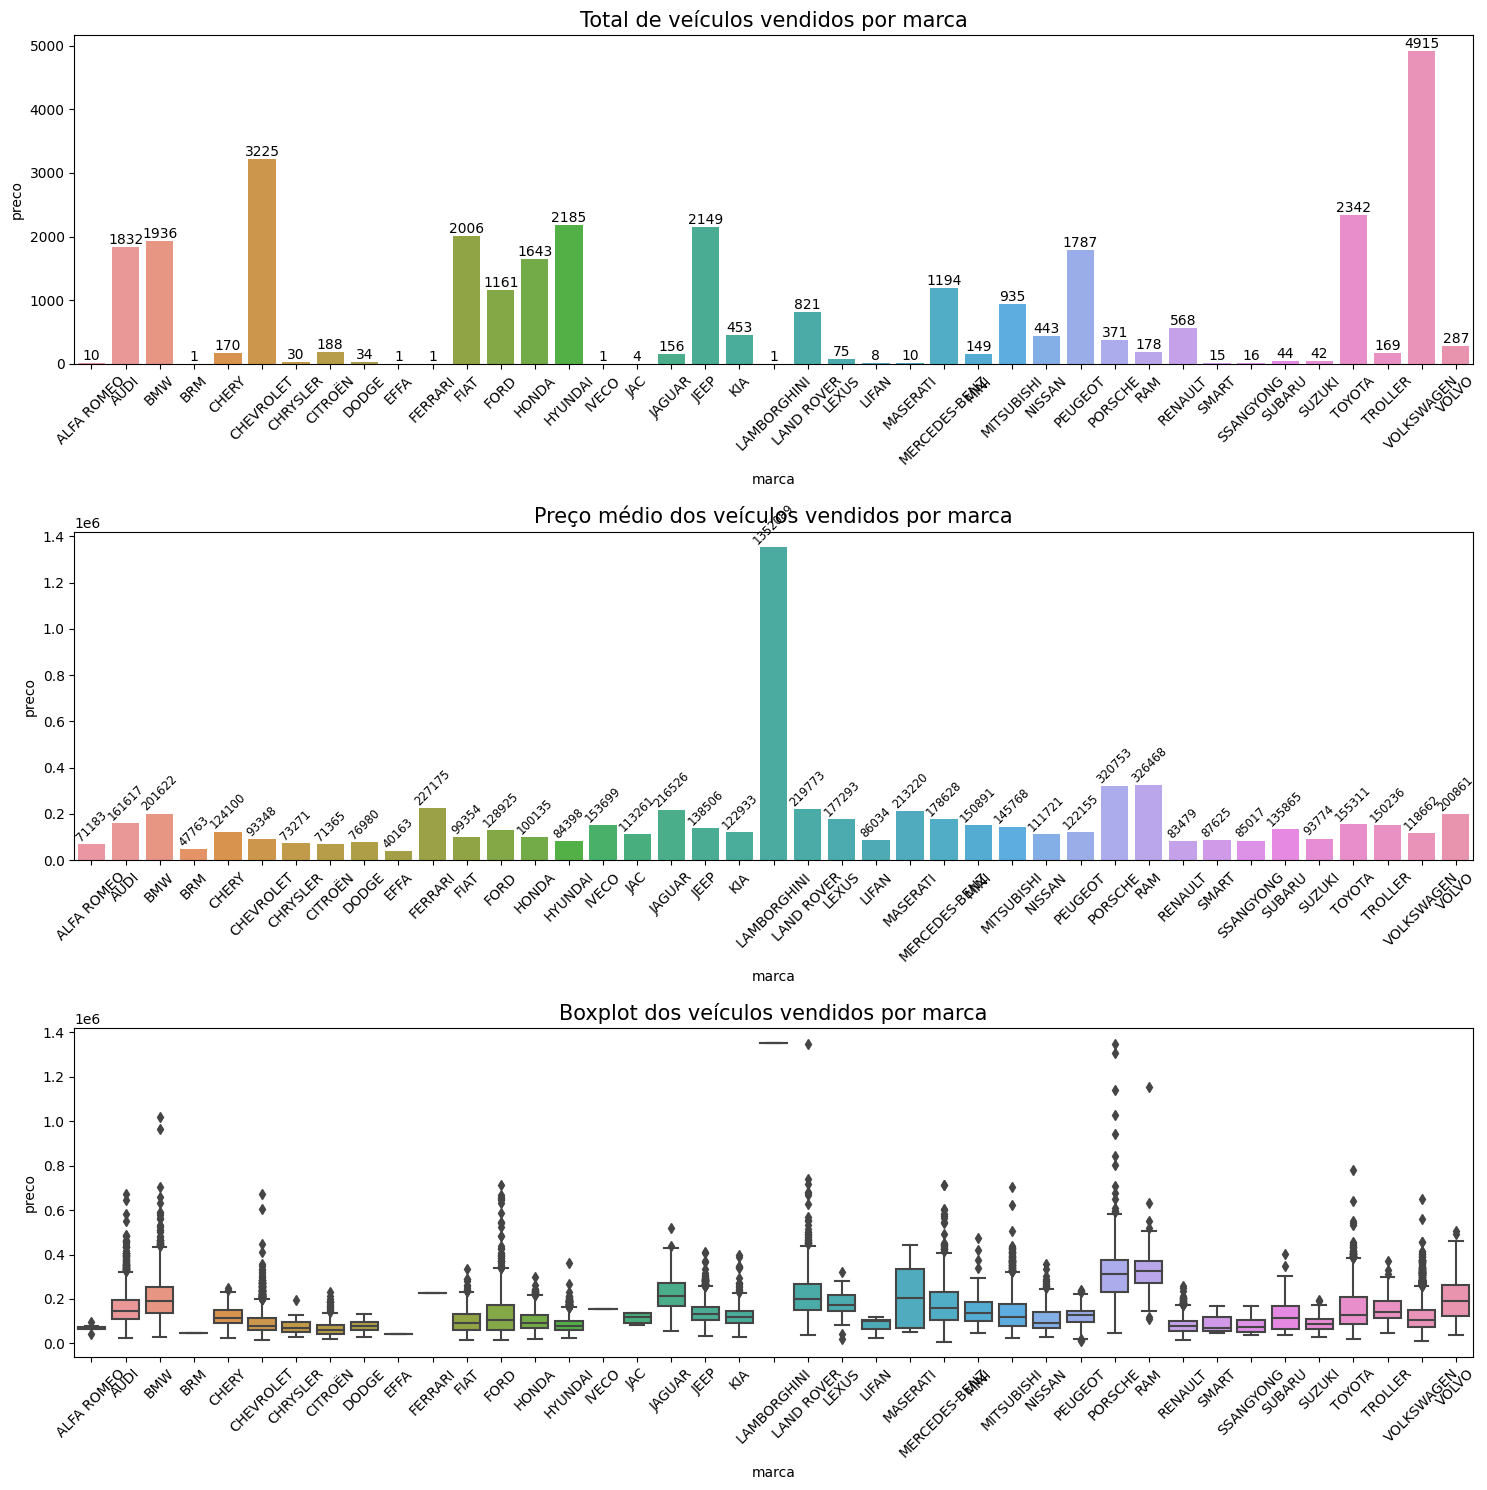

In [152]:
plt.figure(figsize=(15,15))
grid = gridspec.GridSpec(3,1)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por marca', fontsize=15)
aux = df5[['marca','preco']].groupby('marca').count().reset_index().sort_values(by='marca')
g = sns.barplot(x='marca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[1,0])
plt.title('Preço médio dos veículos vendidos por marca', fontsize=15)
aux = df5[['marca','preco']].groupby('marca').mean().reset_index().sort_values(by='marca')
g = sns.barplot(x='marca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[2,0])
plt.title('Boxplot dos veículos vendidos por marca', fontsize=15)
aux = df5.sort_values(by='marca')
sns.boxplot(x='marca', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Modelo

- Variável com várias labels
- Encoding: **Frequency Encoding**

In [153]:
print('Total de modelo diferentes: {}'.format(df5['modelo'].unique().shape[0]))

Total de modelo diferentes: 466


#### Versão

- Variável com várias labels
- Encoding: **Frequency Encode**

In [154]:
print('Total de versões diferentes: {}'.format(df5['versao'].unique().shape[0]))

Total de versões diferentes: 1631


#### Cambio

- Cambios com complexidades distintas
- Rescaling: **Ordinal Enconding** pela mediana dos preços uma vez que traduz a complexidade do cambio

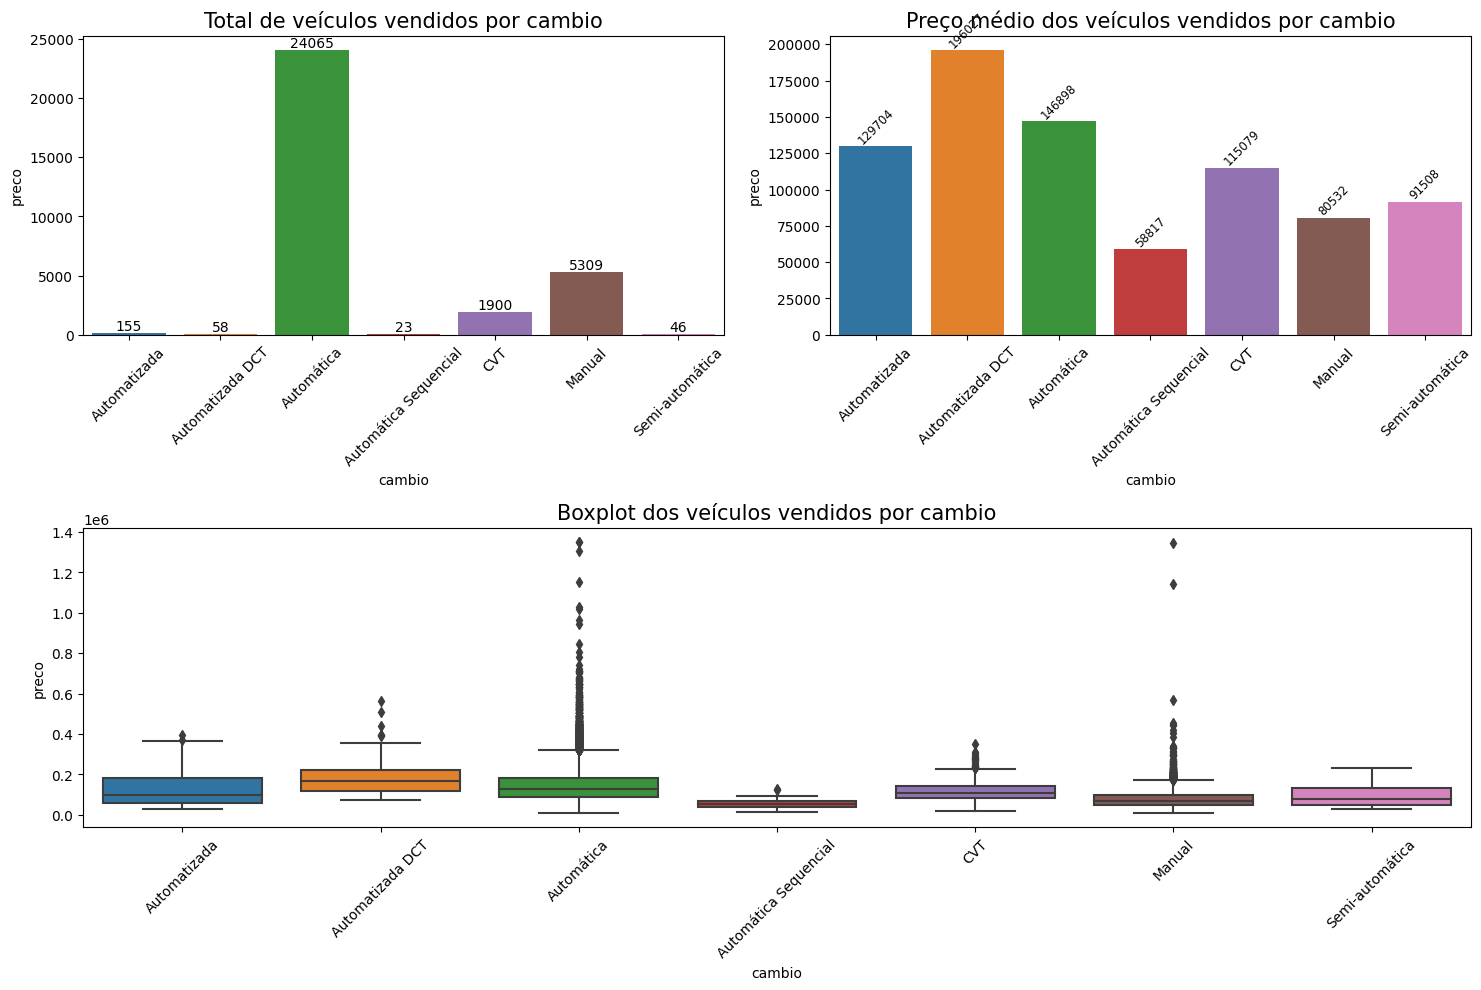

In [155]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cambio', fontsize=15)
aux = df5[['cambio','preco']].groupby('cambio').count().reset_index().sort_values(by='cambio')
g = sns.barplot(x='cambio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cambio', fontsize=15)
aux = df5[['cambio','preco']].groupby('cambio').mean().reset_index().sort_values(by='cambio')
g = sns.barplot(x='cambio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',fontsize='small',rotation=45)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cambio', fontsize=15)
aux = df5.sort_values(by='cambio')
sns.boxplot(x='cambio', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Tipo

- Média de preços bem definida entre os tipos
- Encoding: **Tareget Encoding**

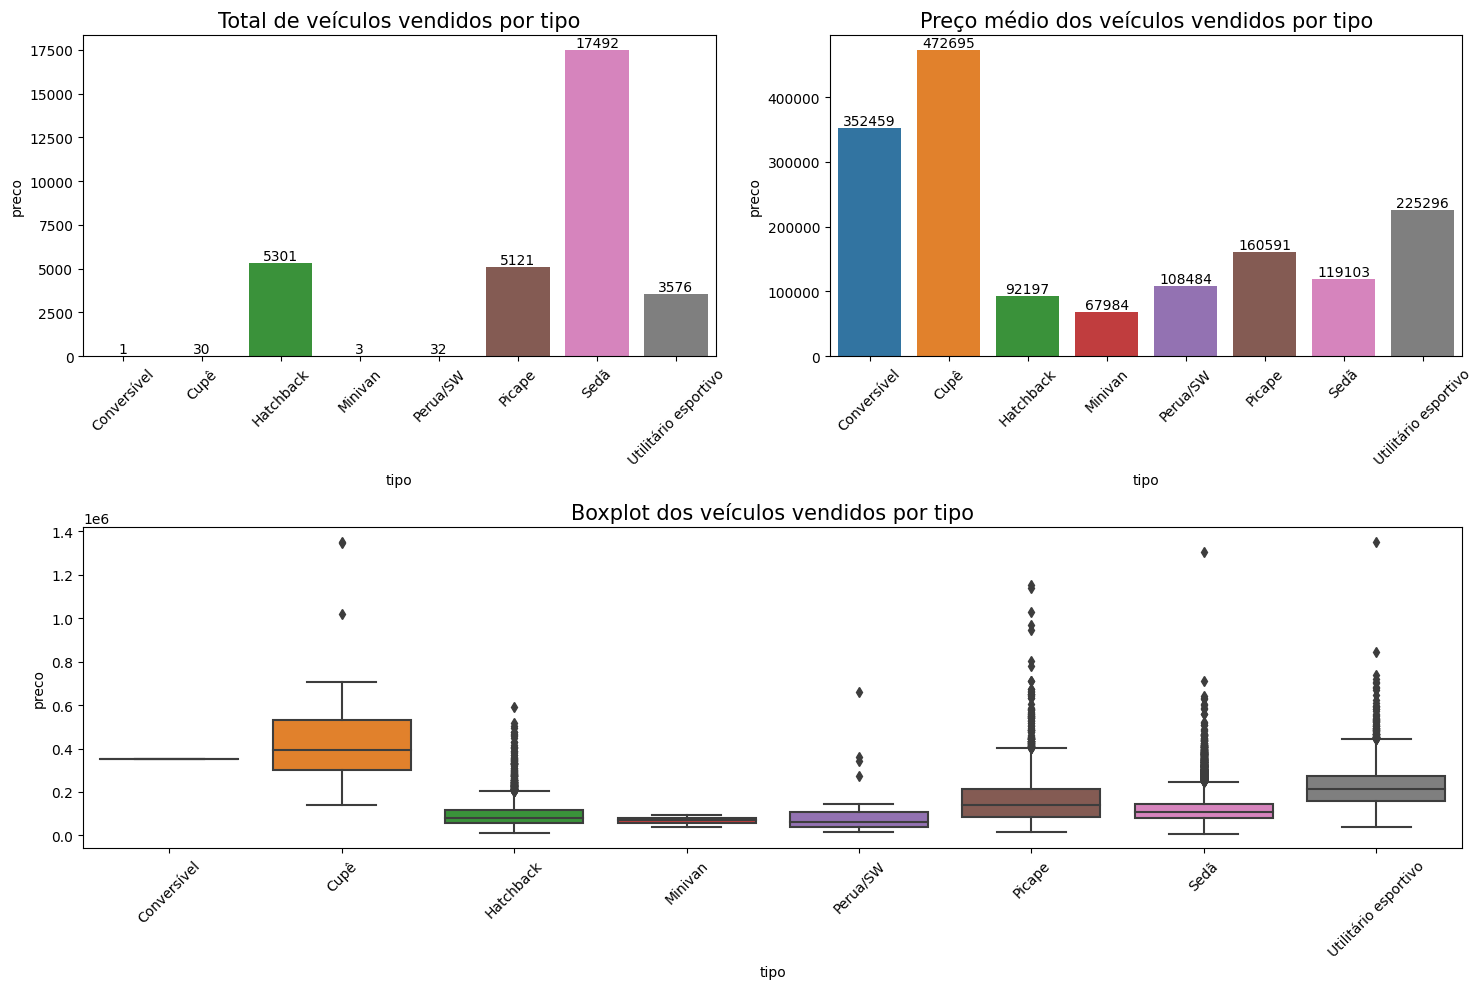

In [156]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo', fontsize=15)
aux = df5[['tipo','preco']].groupby('tipo').count().reset_index().sort_values(by='tipo')
g = sns.barplot(x='tipo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo', fontsize=15)
aux = df5[['tipo','preco']].groupby('tipo').mean().reset_index().sort_values(by='tipo')
g = sns.barplot(x='tipo', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por tipo', fontsize=15)
aux = df5.sort_values(by='tipo')
sns.boxplot(x='tipo', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Blindado

- Possui apenas duas labels e traduz uma ideia de estado
- Encoding: **One Hot Encoding**

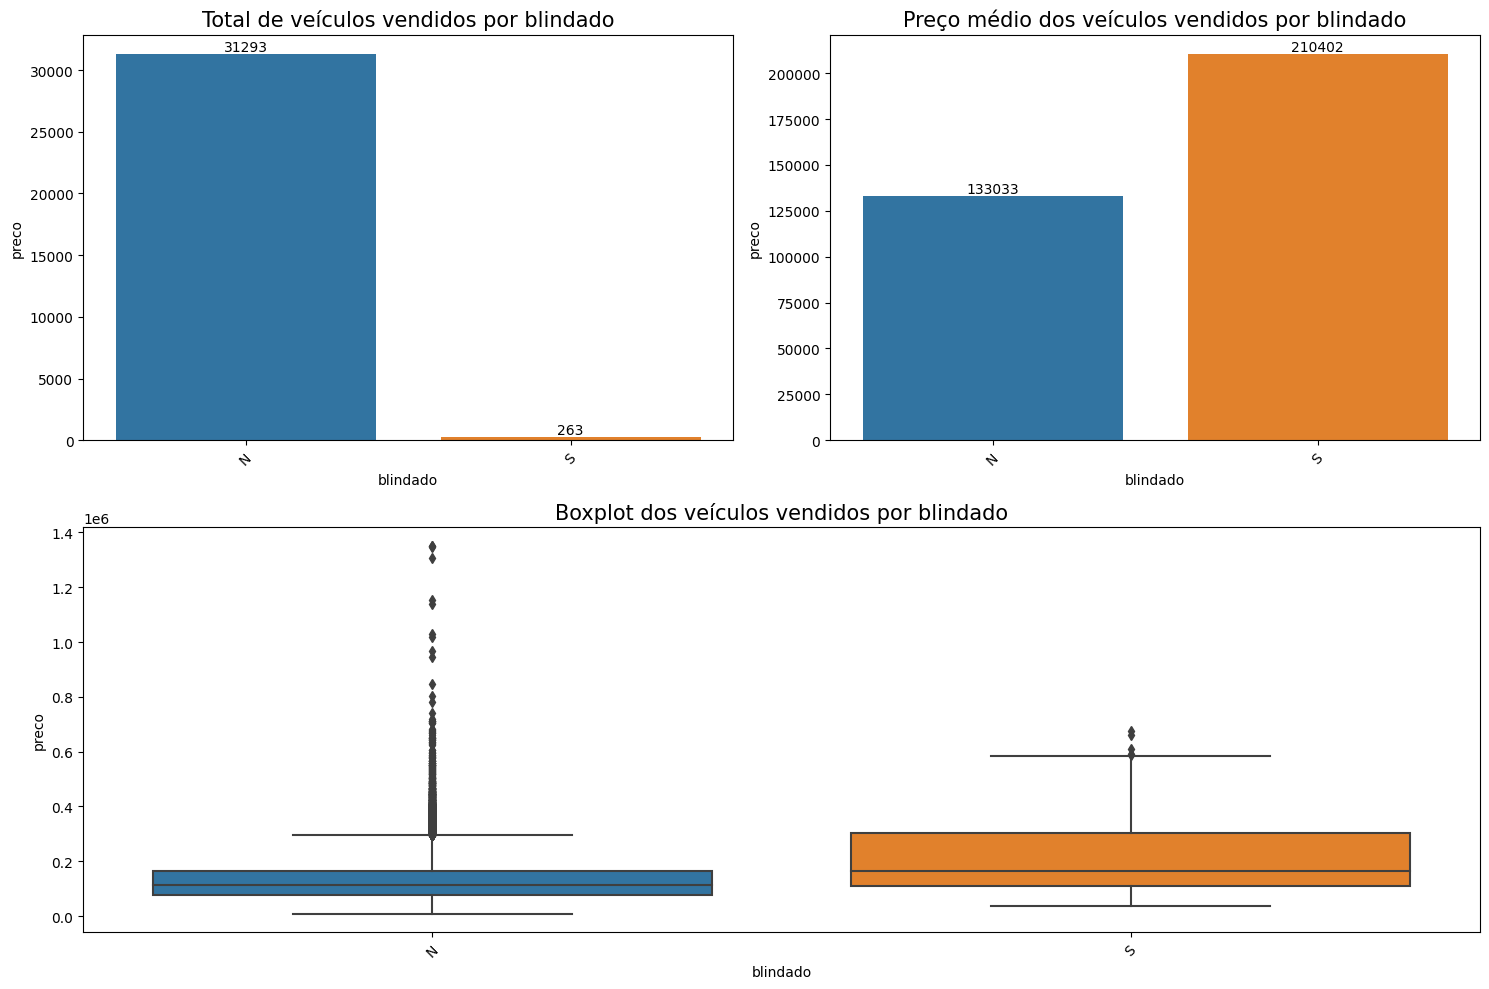

In [157]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por blindado', fontsize=15)
aux = df5[['blindado','preco']].groupby('blindado').count().reset_index().sort_values(by='blindado')
g = sns.barplot(x='blindado', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por blindado', fontsize=15)
aux = df5[['blindado','preco']].groupby('blindado').mean().reset_index().sort_values(by='blindado')
g = sns.barplot(x='blindado', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por blindado', fontsize=15)
aux = df5.sort_values(by='blindado')
sns.boxplot(x='blindado', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cor

- Variável com muitas labels
- Encoding: **Target Encoding**

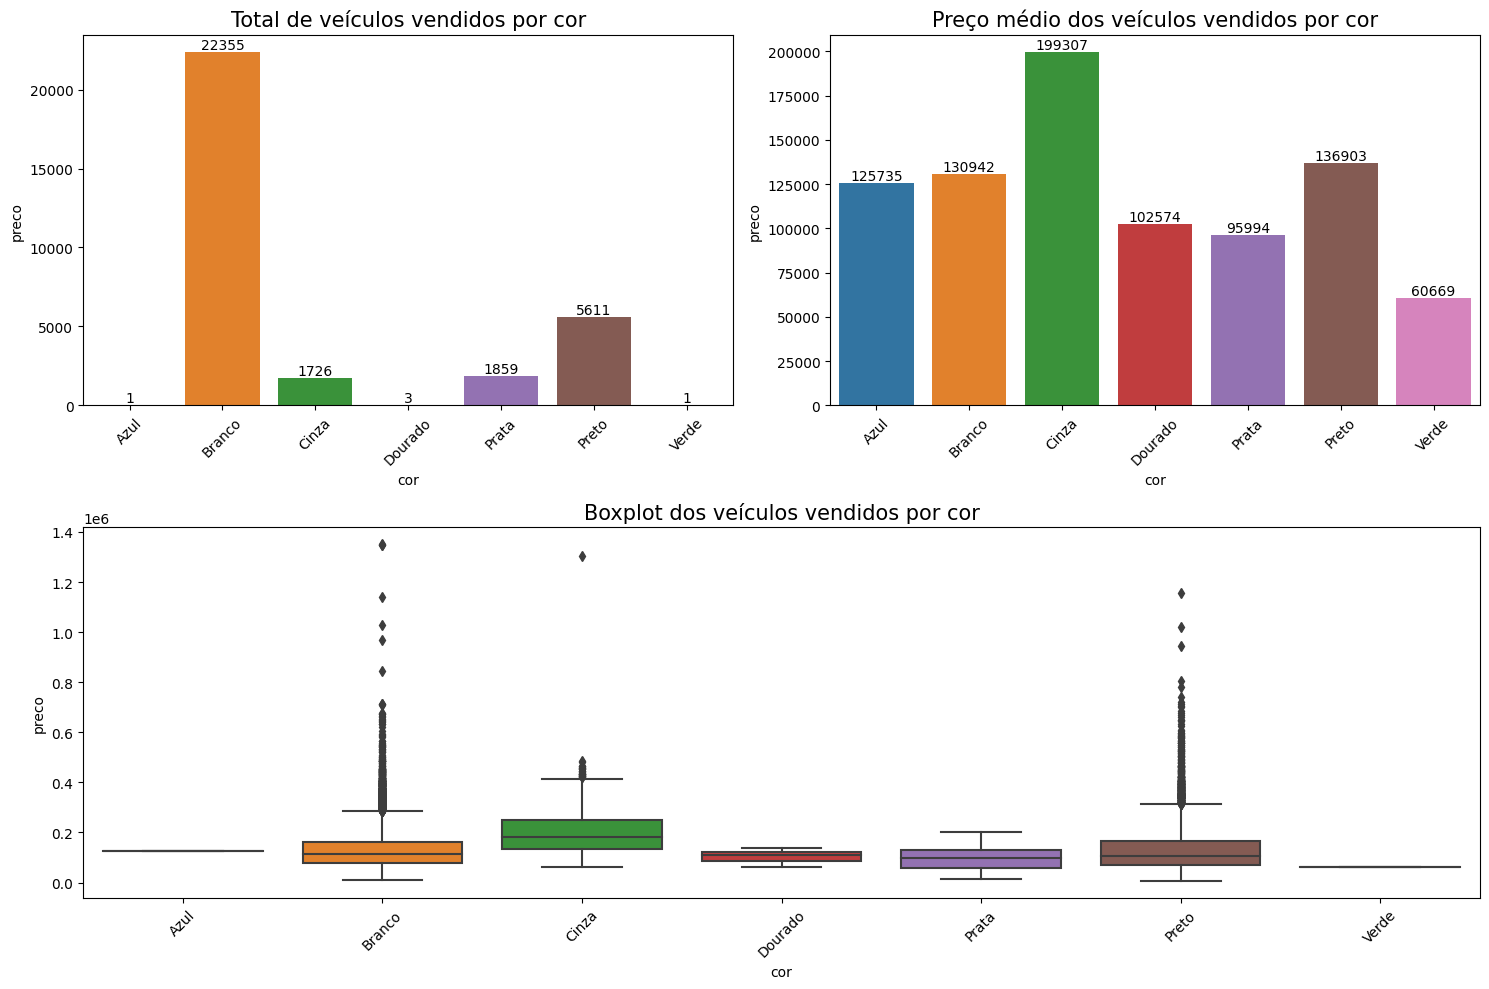

In [158]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cor', fontsize=15)
aux = df5[['cor','preco']].groupby('cor').count().reset_index().sort_values(by='cor')
g = sns.barplot(x='cor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cor', fontsize=15)
aux = df5[['cor','preco']].groupby('cor').mean().reset_index().sort_values(by='cor')
g = sns.barplot(x='cor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cor', fontsize=15)
aux = df5.sort_values(by='cor')
sns.boxplot(x='cor', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Tipo de Vendedor

- Variável com poucas labels. Representa uma ideia de estado (S ou N)
- Encoding: **One Hot Encoding**

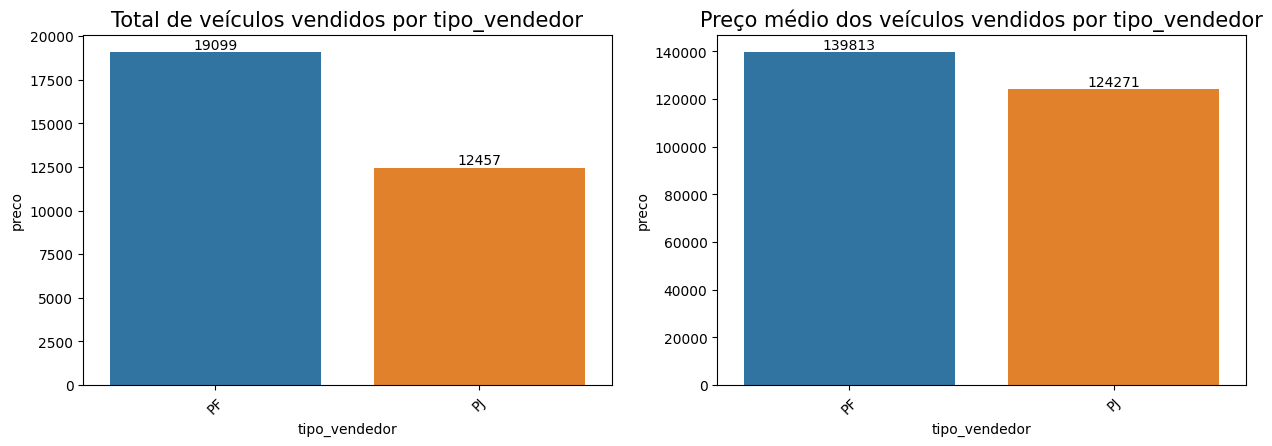

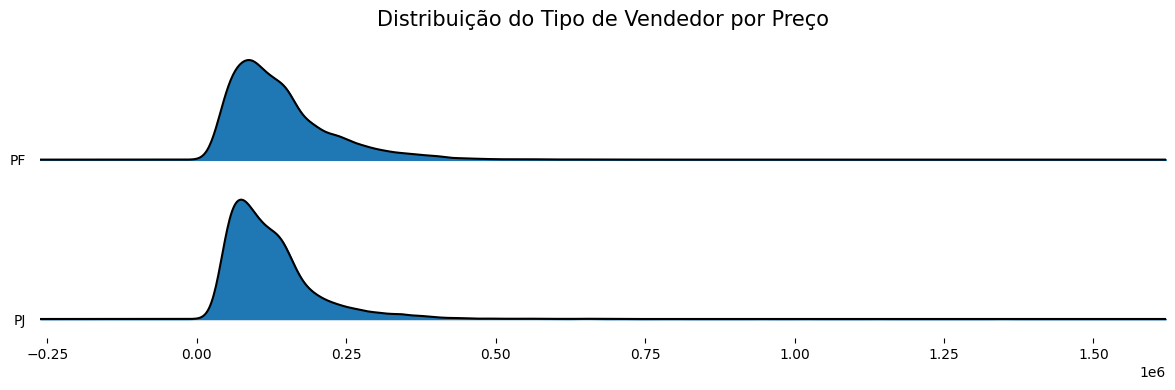

In [159]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo_vendedor', fontsize=15)
aux = df5[['tipo_vendedor','preco']].groupby('tipo_vendedor').count().reset_index().sort_values(by='tipo_vendedor')
g = sns.barplot(x='tipo_vendedor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo_vendedor', fontsize=15)
aux = df5[['tipo_vendedor','preco']].groupby('tipo_vendedor').mean().reset_index().sort_values(by='tipo_vendedor')
g = sns.barplot(x='tipo_vendedor', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

# plt.subplot(grid[1,:])
# plt.title('Boxplot dos veículos vendidos por tipo_vendedor', fontsize=15)
# aux = df5.sort_values(by='tipo_vendedor')
# sns.boxplot(x='tipo_vendedor', y = 'preco', data=aux)
# plt.xticks(rotation=45);

joyplot(df5, by='tipo_vendedor', column='preco', figsize=(12,4))
plt.title('Distribuição do Tipo de Vendedor por Preço', fontsize=15)
plt.tight_layout()

#### Cidade do Vendedor

- Variável com muitos labels
- Encoding: **Target Enconde**

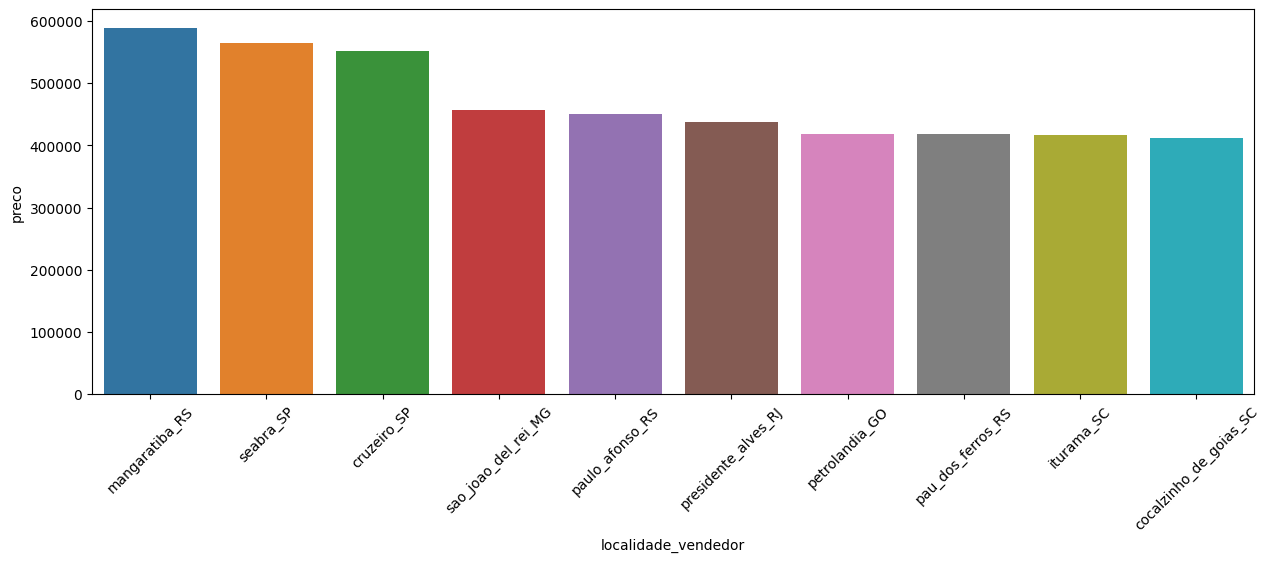

In [160]:
plt.figure(figsize=(15,5))
aux = df5[['localidade_vendedor','preco']].groupby('localidade_vendedor').mean().reset_index().sort_values(by='preco',ascending=False)[:10]
sns.barplot(x='localidade_vendedor', y = 'preco', data=aux)
plt.xticks(rotation=45);

#### Tipo de Anúncio

- Variáveis com labels que representam uma ideia de estado
- Encoding: **One Hot Encoding**

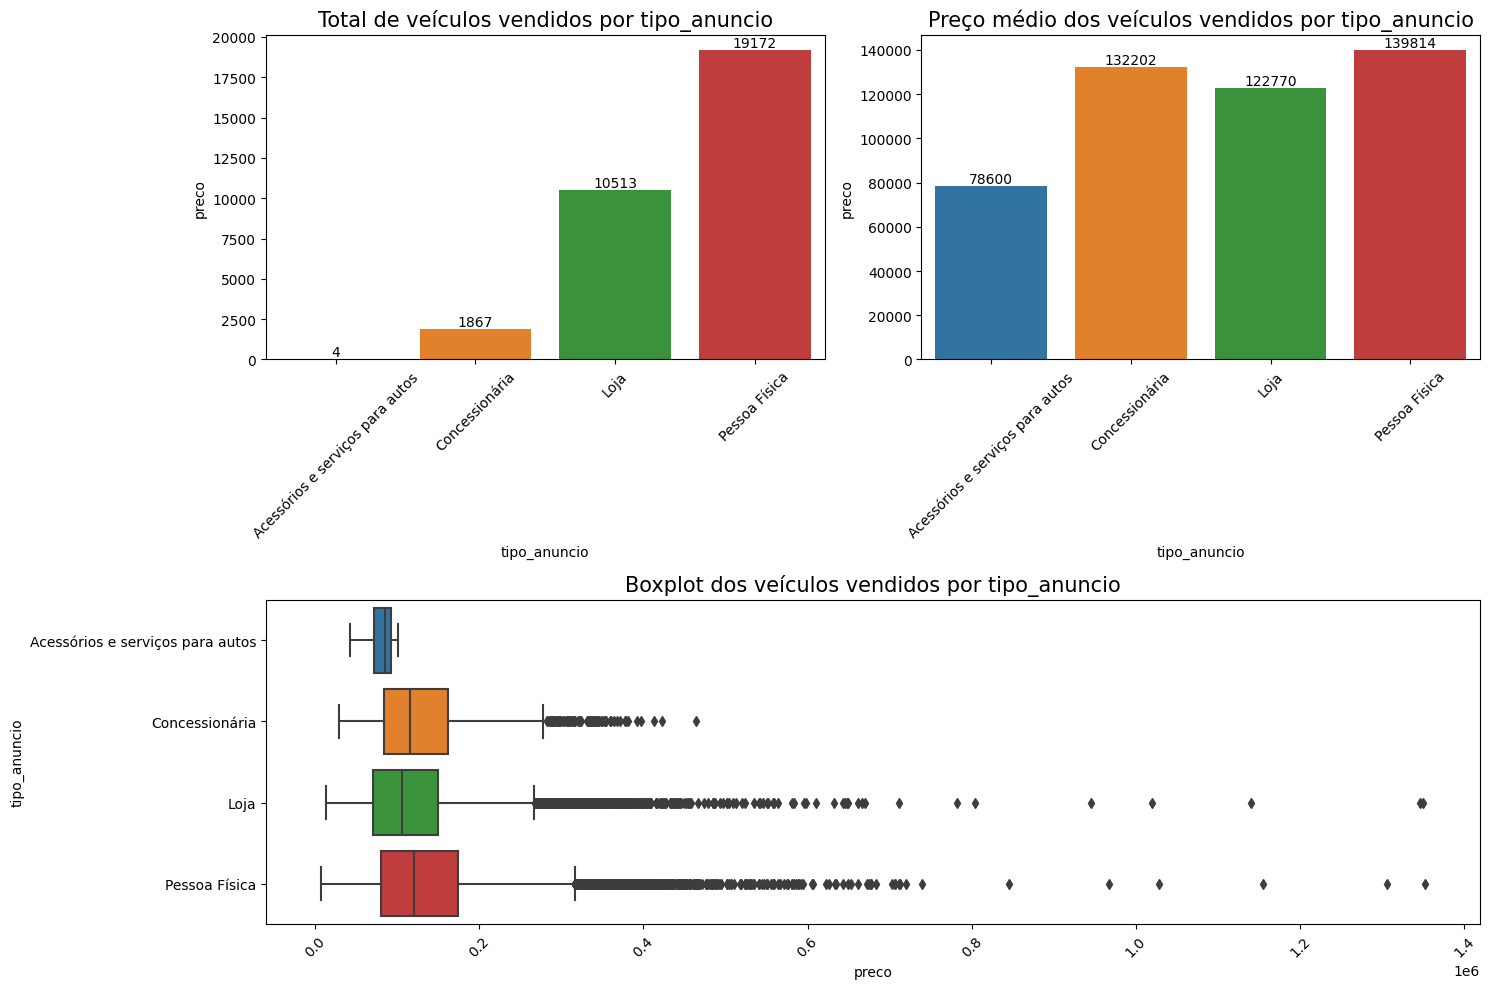

In [161]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5[['tipo_anuncio','preco']].groupby('tipo_anuncio').count().reset_index().sort_values(by='tipo_anuncio')
g = sns.barplot(x='tipo_anuncio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5[['tipo_anuncio','preco']].groupby('tipo_anuncio').mean().reset_index().sort_values(by='tipo_anuncio')
g = sns.barplot(x='tipo_anuncio', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por tipo_anuncio', fontsize=15)
aux = df5.sort_values(by='tipo_anuncio')
sns.boxplot(x='preco', y = 'tipo_anuncio', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Entrega Delivery

- Variável binária
- Encoding: **One Hot Encoding**

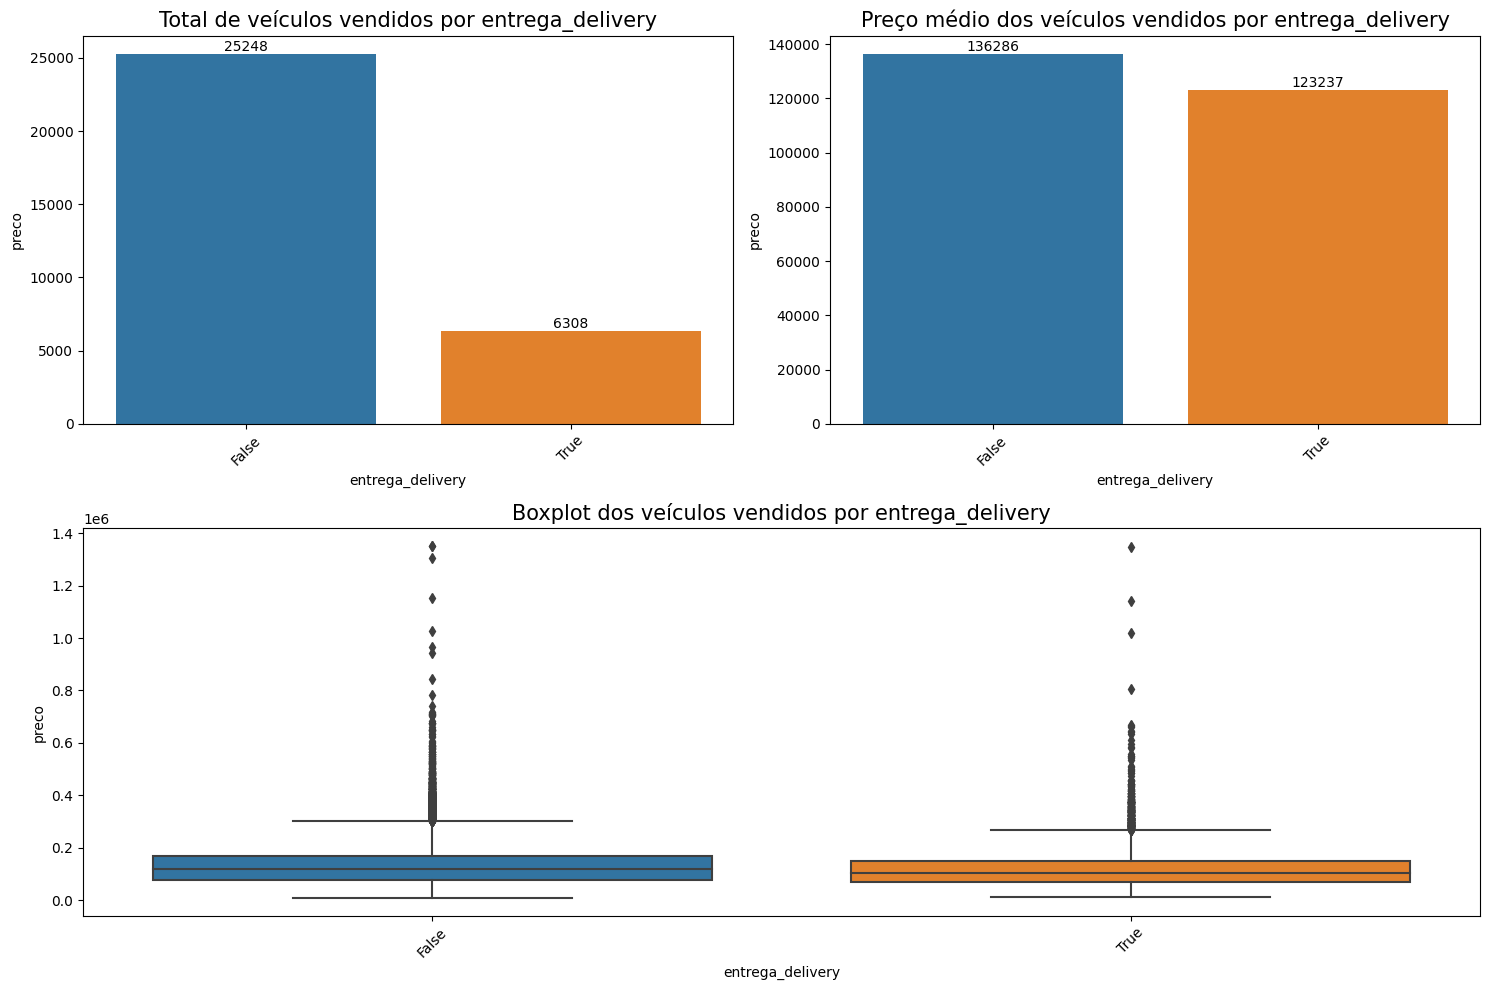

In [162]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por entrega_delivery', fontsize=15)
aux = df5[['entrega_delivery','preco']].groupby('entrega_delivery').count().reset_index().sort_values(by='entrega_delivery')
g = sns.barplot(x='entrega_delivery', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por entrega_delivery', fontsize=15)
aux = df5[['entrega_delivery','preco']].groupby('entrega_delivery').mean().reset_index().sort_values(by='entrega_delivery')
g = sns.barplot(x='entrega_delivery', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por entrega_delivery', fontsize=15)
aux = df5.sort_values(by='entrega_delivery')
sns.boxplot(x='entrega_delivery', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Troca

- Variável pouco significativa
- Remover

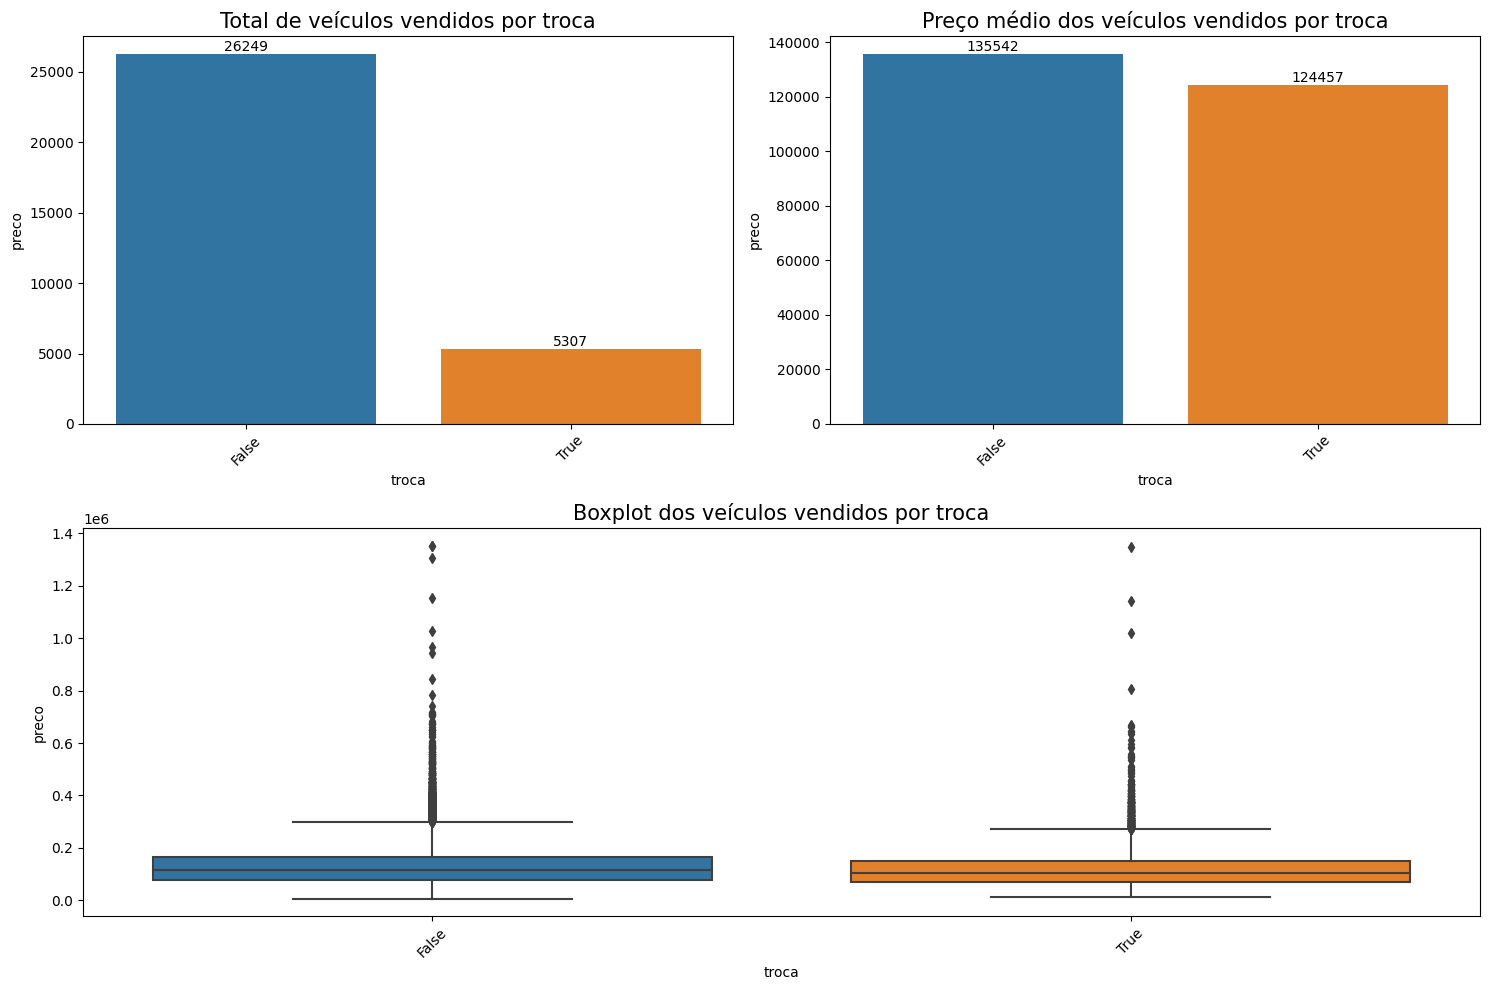

In [163]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por troca', fontsize=15)
aux = df5[['troca','preco']].groupby('troca').count().reset_index().sort_values(by='troca')
g = sns.barplot(x='troca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por troca', fontsize=15)
aux = df5[['troca','preco']].groupby('troca').mean().reset_index().sort_values(by='troca')
g = sns.barplot(x='troca', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por troca', fontsize=15)
aux = df5.sort_values(by='troca')
sns.boxplot(x='troca', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Elegível revisão

- Variável pouco significativa
- Remover

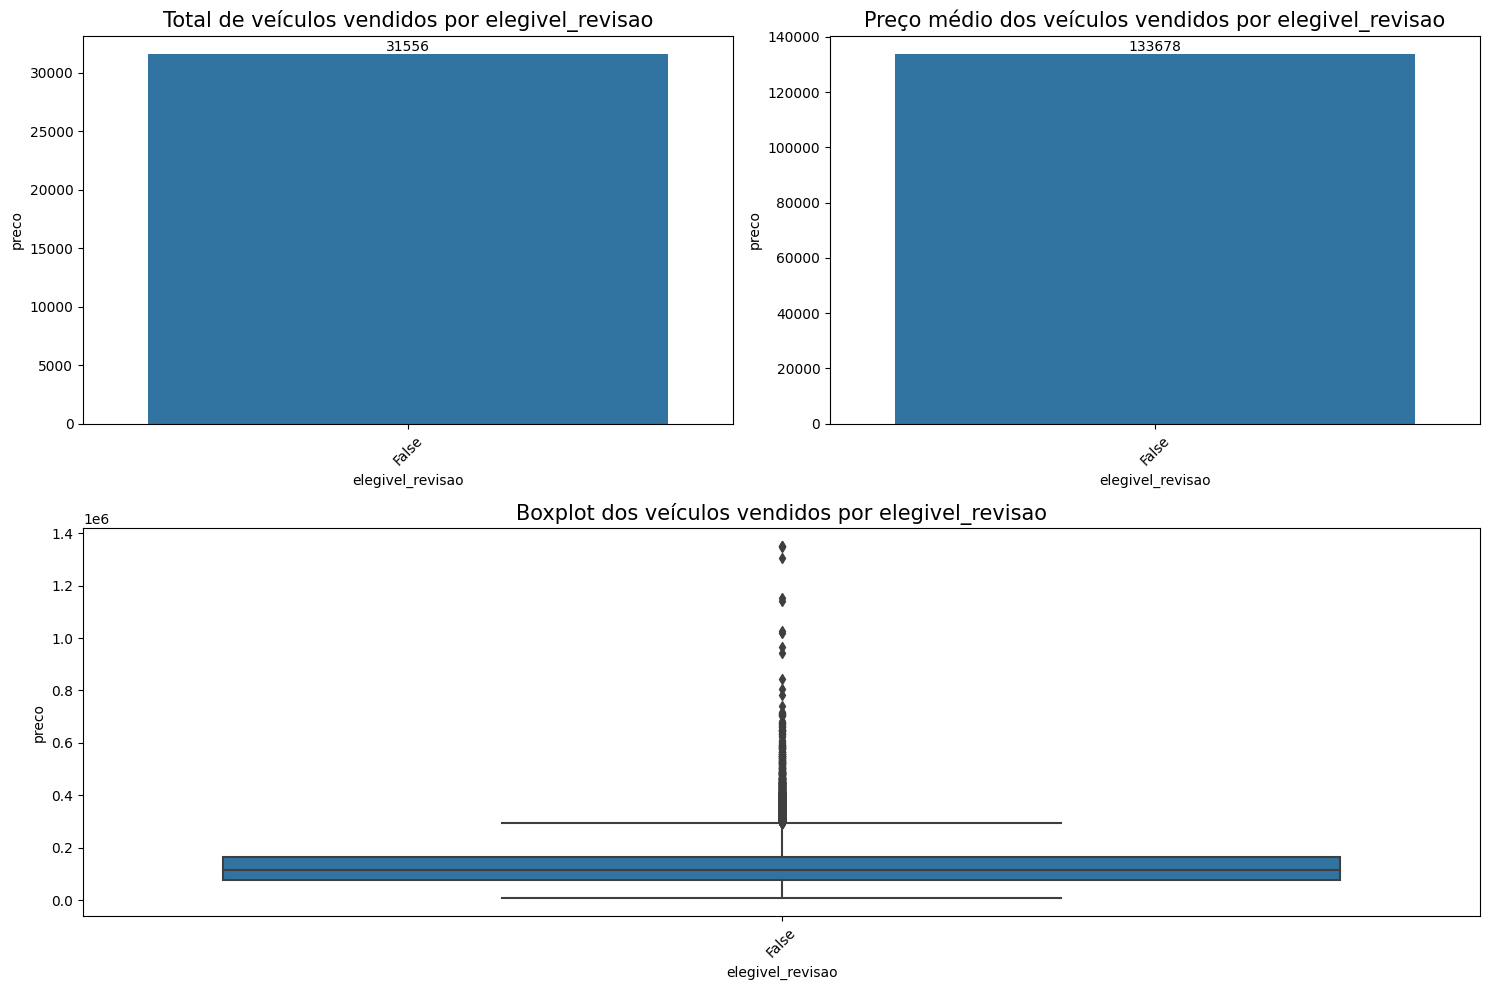

In [164]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5[['elegivel_revisao','preco']].groupby('elegivel_revisao').count().reset_index().sort_values(by='elegivel_revisao')
g = sns.barplot(x='elegivel_revisao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5[['elegivel_revisao','preco']].groupby('elegivel_revisao').mean().reset_index().sort_values(by='elegivel_revisao')
g = sns.barplot(x='elegivel_revisao', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por elegivel_revisao', fontsize=15)
aux = df5.sort_values(by='elegivel_revisao')
sns.boxplot(x='elegivel_revisao', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Cilindradas

- Hipótese de que quanto mais raro o veículo com determinadas cilindradas, mais caro
- Encode: Frequency Encode

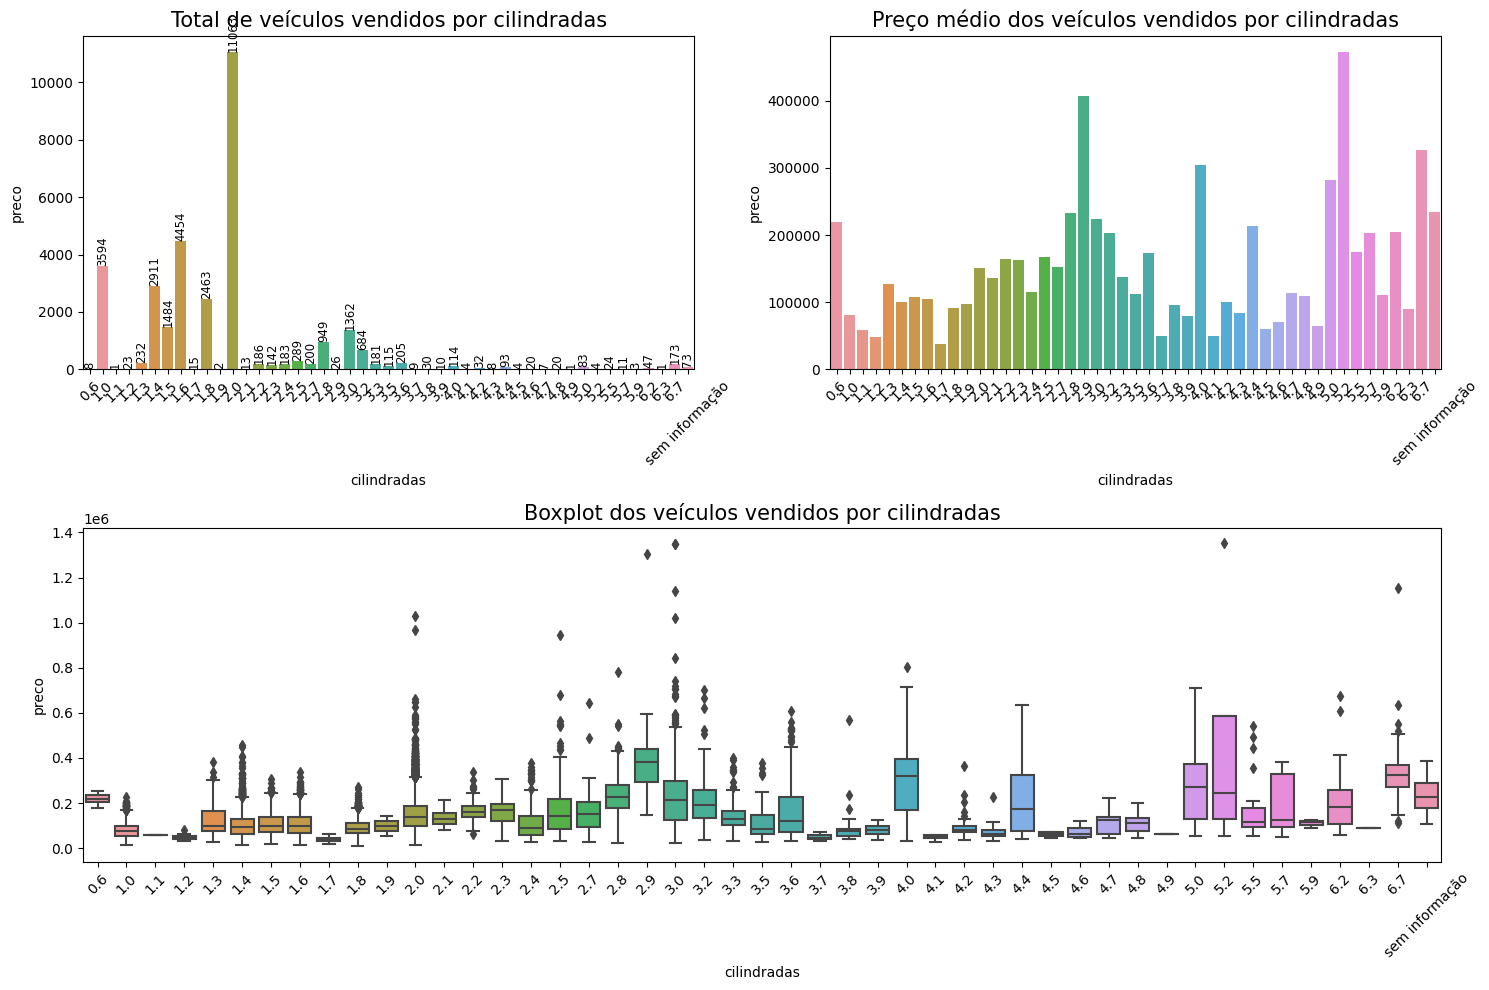

In [165]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por cilindradas', fontsize=15)
aux = df5[['cilindradas','preco']].groupby('cilindradas').count().reset_index().sort_values(by='cilindradas')
g = sns.barplot(x='cilindradas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=90, fontsize='small')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por cilindradas', fontsize=15)
aux = df5[['cilindradas','preco']].groupby('cilindradas').mean().reset_index().sort_values(by='cilindradas')
g = sns.barplot(x='cilindradas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por cilindradas', fontsize=15)
aux = df5.sort_values(by='cilindradas')
sns.boxplot(x='cilindradas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Válvulas

- Variável com muitas labels
- Encoding: **Target Encoding**

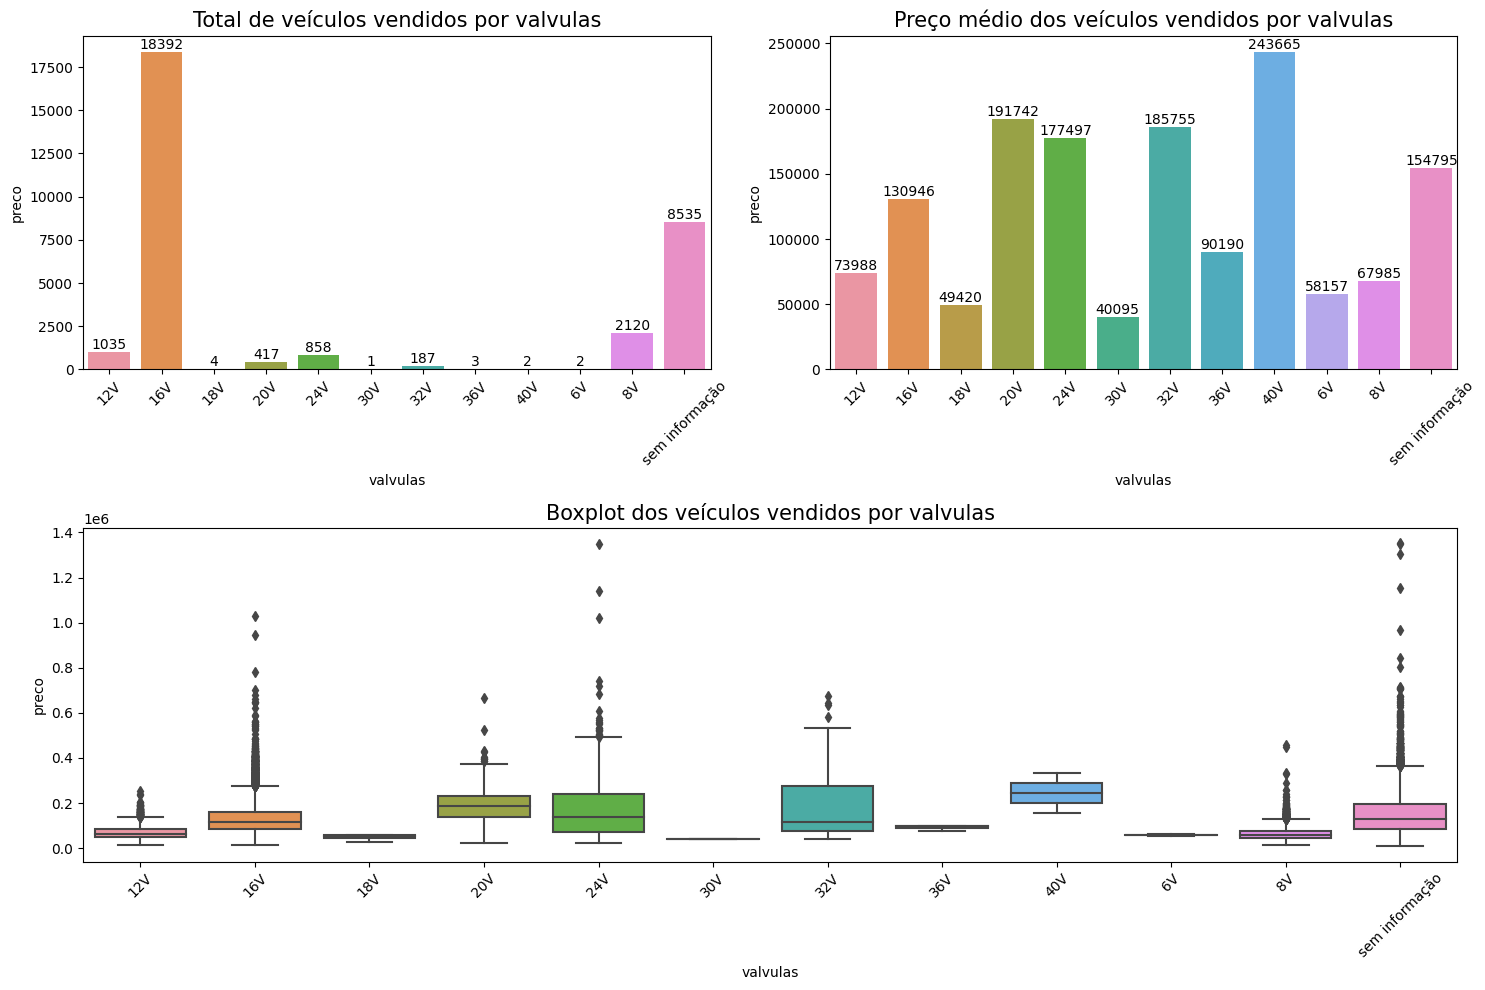

In [166]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por valvulas', fontsize=15)
aux = df5[['valvulas','preco']].groupby('valvulas').count().reset_index().sort_values(by='valvulas')
g = sns.barplot(x='valvulas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por valvulas', fontsize=15)
aux = df5[['valvulas','preco']].groupby('valvulas').mean().reset_index().sort_values(by='valvulas')
g = sns.barplot(x='valvulas', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por valvulas', fontsize=15)
aux = df5.sort_values(by='valvulas')
sns.boxplot(x='valvulas', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

#### Combustivel

- Variável com muitas labels
- Encoding: **Frequency Encoding**

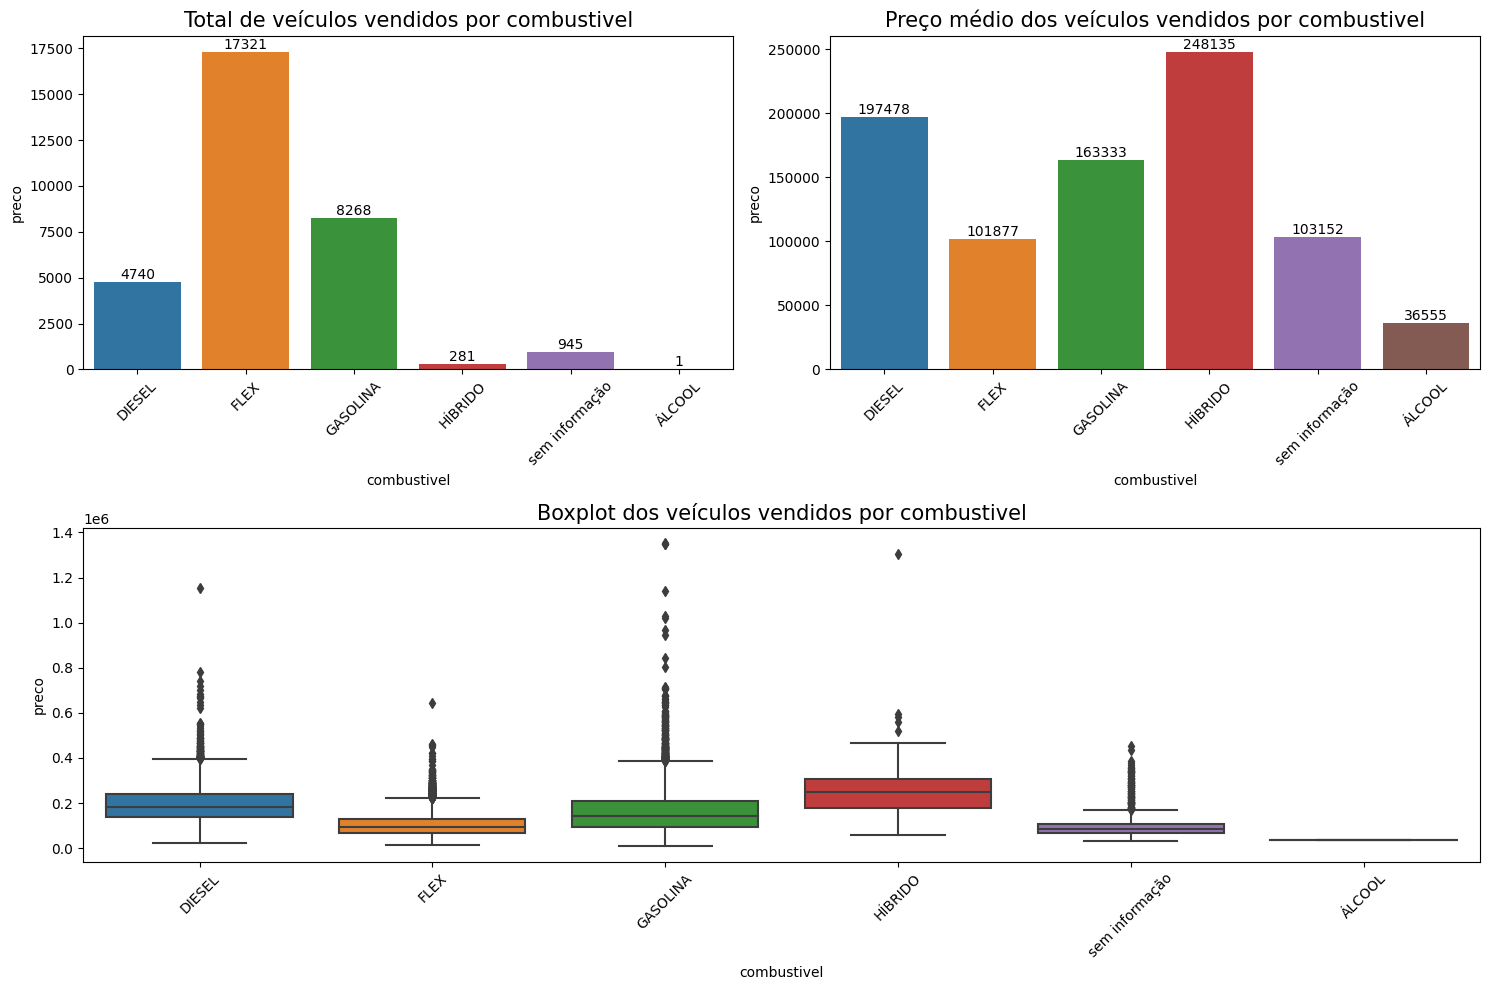

In [167]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
plt.title('Total de veículos vendidos por combustivel', fontsize=15)
aux = df5[['combustivel','preco']].groupby('combustivel').count().reset_index().sort_values(by='combustivel')
g = sns.barplot(x='combustivel', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f')
plt.xticks(rotation=45);

plt.subplot(grid[0,1])
plt.title('Preço médio dos veículos vendidos por combustivel', fontsize=15)
aux = df5[['combustivel','preco']].groupby('combustivel').mean().reset_index().sort_values(by='combustivel')
g = sns.barplot(x='combustivel', y = 'preco', data=aux)
for i in g.containers:
    g.bar_label(i, fmt='%0.0f',rotation=0)
plt.xticks(rotation=45);

plt.subplot(grid[1,:])
plt.title('Boxplot dos veículos vendidos por combustivel', fontsize=15)
aux = df5.sort_values(by='combustivel')
sns.boxplot(x='combustivel', y = 'preco', data=aux)
plt.xticks(rotation=45);

plt.tight_layout()

# Data Preparation

In [168]:
df6 = df5.copy()

In [169]:
# data Split

X_train = df6.drop('preco', axis=1)
y_train = df6['preco']

X_test = data_test.drop('preco', axis=1)
y_test = data_test['preco']

In [170]:
print(f'Treino: {X_train.shape[0]}')
print(f'Test: {X_test.shape[0]}')

Treino: 31556
Test: 7890


## Transformando variável resposta

In [171]:
y_train = pd.DataFrame(np.log1p(y_train))

## Standarization

In [172]:
sc = pp.StandardScaler()
y_train_norm= sc.fit_transform(y_train)
pickle.dump(sc, open('api/parameters/sc_response.pkl','wb'))

sc = pp.StandardScaler()
X_train['km_media_ano_em_1k_km'] = sc.fit_transform(X_train[['km_media_ano_em_1k_km']])
pickle.dump(sc, open('api/parameters/sc_km_media_ano.pkl','wb'))

## Rescaling

| Atributo               | Rescaling  |
| ---------------------- | ------------- |
|**ano_de_fabricação** | Robust Scaler |
|**ano_modelo:** | Robust Scaler|
|**odometro:** | Robust Scaler|
|**num_portas:** | Ordinal Encode|

### Robust Scaler

In [173]:
rs = pp.RobustScaler()

X_train['ano_de_fabricacao'] = rs.fit_transform(X_train[['ano_de_fabricacao']])
pickle.dump(rs, open('api/parameters/rs_ano_de_fabricacao.pkl','wb'))

X_train['ano_modelo'] = rs.fit_transform(X_train[['ano_modelo']])
pickle.dump(rs, open('api/parameters/rs_ano_modelo.pkl','wb'))

X_train['odometro'] = rs.fit_transform(X_train[['odometro']])
pickle.dump(rs, open('api/parameters/rs_odometro.pkl','wb'))

## Encodings

| Atributo                | Encode          |
| ----------------------- | --------------- |
| **marca:**              | Frequency Encode| 
| **modelo:**             | Frequency Encode| 
| **versao:**             | Frequency Encode| 
| **cambio:**             | Ordinal Enconde| 
| **tipo:**               | Target Encode| 
| **blindado:**           | One Hot Encode| 
| **cor:**                | Target Encode| 
| **tipo_vendedor:**   | One Hot Encode| 
| **cidade_vendedor:** | Target Encode| 
| **tipo_anuncio:**   | One Hot Encode| 
| **cilindradas:**        | Frequency Encode| 
| **valvulas:**           | Target Encode| 
| **combustivel:**        | Target Encode| 

### One Hot Encode

In [174]:
# blindado
X_train['blindado'] = X_train['blindado'].replace({'S':1, 'N':0})

# tipo_vendedor
X_train['tipo_vendedor'] = X_train['tipo_vendedor'].replace({'PJ':1, 'PF':0})

# tipo_anuncio
oe = pp.OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train['tipo_anuncio'] = X_train['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
cols_dummies = oe.fit_transform(X_train['tipo_anuncio'].values.reshape(-1,1))
X_train[oe.categories_[0]] = cols_dummies
pickle.dump(oe,open(f'api/parameters/oe_tipo_anuncio.pkl', 'wb'))

X_train['cambio'] = X_train['cambio'].map({'Manual':0,
                                            'Automática Sequencial':1, 
                                            'Semi-automática':2,
                                            'CVT':3,
                                            'Automatizada':4,
                                            'Automática':4,
                                            'Automatizada DCT':5
                                            })

X_train['num_portas'] = X_train['num_portas'].apply(lambda x: 1 if x > 2 else 0)

In [175]:
X_train.head()

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo,acessorios_e_servicos_para_autos,concessionaria,loja,pessoa_fisica
11966,PEUGEOT,3008,GRIFFE PACK THP 4P,0.25,0.5,-0.594145,4,1,Utilitário esportivo,0,...,1.6,16V,GASOLINA,goiania_GO,-0.619277,PEUGEOT_3008,0.0,0.0,0.0,1.0
10300,FORD,ECOSPORT,TI-VCT SE,0.50,0.5,0.104796,4,1,Sedã,0,...,1.5,sem informação,FLEX,sao_jose_do_rio_preto_SP,1.756896,FORD_ECOSPORT,0.0,0.0,1.0,0.0
10009,FIAT,TORO,EVO FREEDOM AT6,0.25,0.5,-0.060913,4,1,Picape,0,...,1.8,16V,FLEX,sao_paulo_SP,1.228857,FIAT_TORO,0.0,0.0,1.0,0.0
30671,CHEVROLET,JOY,SPE4,0.25,0.5,-0.735776,0,1,Hatchback,0,...,1.0,sem informação,FLEX,rio_de_janeiro_RJ,-1.147315,CHEVROLET_JOY,0.0,0.0,0.0,1.0
32870,FORD,RANGER,XLS 4X4 CD 4P,-0.25,0.0,0.946982,4,1,Picape,0,...,2.2,16V,DIESEL,medianeira_PR,2.284934,FORD_RANGER,0.0,0.0,0.0,1.0


### Target Enconde

In [176]:
for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
    te = ce.TargetEncoder(cols=[att], handle_unknown = 'return_nan').fit(X_train, y_train_norm)
    pickle.dump(te, open(f'api/parameters/te_{att}.pkl','wb'))
    X_train = te.transform(X_train)

### Frequency Encode

In [177]:
for att in ['marca', 'modelo','versao','cilindradas']:
    fe =  ce.CountEncoder(cols=[att], normalize=True, handle_unknown = 'return_nan').fit(X_train)
    pickle.dump(fe,open(f'api/parameters/fe_{att}.pkl', 'wb'))
    X_train = fe.transform(X_train)

## Test Preparation

In [178]:
X_test = X_test.drop(cols_drop, axis=1)

In [179]:
y_test = pd.DataFrame(np.log1p(y_test))

# extraindo as cilindradas da coluna versão
X_test['cilindradas'] = X_test['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

# extraindo válvulas da coluna versão
X_test['valvulas'] = X_test['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

# extraindo combustível da coluna versão
X_test['combustivel'] = X_test['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                   'FLEX' if 'FLEX'     in x else 
                                                   'DIESEL' if 'DIESEL'   in x else 
                                                   'ÁLCOOL' if 'ÁLCOOL' in x else
                                                   'HÍBRIDO' if 'HYBRID' in x else
                                                   'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

# removendo features derivadas da coluna original
X_test['versao'] = X_test.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

# retirando acentos, substituindo letras maiúsculas e espaços
X_test['cidade_vendedor'] = X_test['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

# extraindo estado
X_test['estado_vendedor'] = X_test['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

# criando feature de localidade
X_test['localidade_vendedor'] = X_test['cidade_vendedor'] + "_" + X_test['estado_vendedor']

# criando feature de km médio rodado por ano
X_test['km_media_ano_em_1k_km'] = X_test['odometro']/np.round(2023 - X_test['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
X_test['km_media_ano_em_1k_km'] = round(X_test['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
X_test['veiculo'] = X_test['marca'].astype(str) + "_" + X_test['modelo'].astype(str) #+ "_" + X_test['km_media_ano_em_1k_km'].astype(str)

In [180]:
X_test.shape

(7890, 24)

In [181]:
sc = pickle.load(open('api/parameters/sc_km_media_ano.pkl','rb'))
X_test['km_media_ano_em_1k_km'] = sc.transform(X_test[['km_media_ano_em_1k_km']])

# Rescaling
rs = pickle.load(open('api/parameters/rs_ano_de_fabricacao.pkl','rb'))
X_test['ano_de_fabricacao'] = rs.transform(X_test[['ano_de_fabricacao']])

rs = pickle.load(open('api/parameters/rs_ano_modelo.pkl','rb'))
X_test['ano_modelo'] = rs.transform(X_test[['ano_modelo']])

rs = pickle.load(open('api/parameters/rs_odometro.pkl','rb'))
X_test['odometro'] = rs.transform(X_test[['odometro']])

# Encode
## One Hot Encode
# blindado
X_test['blindado'] = X_test['blindado'].replace({'S':1, 'N':0})

# tipo_vendedor
X_test['tipo_vendedor'] = X_test['tipo_vendedor'].replace({'PJ':1, 'PF':0})

# tipo_anuncio
oe = pickle.load(open(f'api/parameters/oe_tipo_anuncio.pkl', 'rb'))
X_test['tipo_anuncio'] = X_test['tipo_anuncio'].apply(lambda x: unidecode(x).lower().replace(' ','_'))
cols_dummies = oe.transform(X_test['tipo_anuncio'].values.reshape(-1,1))
X_test[oe.categories_[0]] = cols_dummies


X_test['cambio'] = X_test['cambio'].map({'Manual':0,
                                            'Automática Sequencial':1, 
                                            'Semi-automática':2,
                                            'CVT':3,
                                            'Automatizada':4,
                                            'Automática':4,
                                            'Automatizada DCT':5
                                            })

X_test['num_portas'] = X_test['num_portas'].apply(lambda x: 1 if x > 2 else 0)

In [182]:
## Target Encode
for att in ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:
    te = pickle.load(open(f'api/parameters/te_{att}.pkl','rb'))
    X_test =te.transform(X_test)

## Frequency Encode
for att in ['marca', 'modelo','versao','cilindradas']:
    fe = pickle.load(open(f'api/parameters/fe_{att}.pkl', 'rb'))
    X_test = fe.transform(X_test)

## KNN Imputer
## Preenche valores de target e frequency encode não encontratos
imputer = KNNImputer(n_neighbors=5, copy=True)
X_test = pd.DataFrame(imputer.fit_transform(X_test.drop(columns=['cidade_vendedor','estado_vendedor','tipo_anuncio'])),columns = X_test.drop(columns=['cidade_vendedor','estado_vendedor', 'tipo_anuncio']).columns)

In [183]:
X_test.isna().sum()

marca                               0
modelo                              0
versao                              0
ano_de_fabricacao                   0
ano_modelo                          0
odometro                            0
cambio                              0
num_portas                          0
tipo                                0
blindado                            0
cor                                 0
tipo_vendedor                       0
entrega_delivery                    0
troca                               0
elegivel_revisao                    0
cilindradas                         0
valvulas                            0
combustivel                         0
localidade_vendedor                 0
km_media_ano_em_1k_km               0
veiculo                             0
acessorios_e_servicos_para_autos    0
concessionaria                      0
loja                                0
pessoa_fisica                       0
dtype: int64

In [184]:
X_test.sample(3)

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,...,cilindradas,valvulas,combustivel,localidade_vendedor,km_media_ano_em_1k_km,veiculo,acessorios_e_servicos_para_autos,concessionaria,loja,pessoa_fisica
1927,0.155755,0.000317,0.000317,-0.25,-0.25,-0.318542,4.0,1.0,1.052072,0.0,...,0.001014,0.357695,0.329538,0.196497,-0.883296,0.103640,0.0,0.0,1.0,0.0
5555,0.005641,0.005482,0.003454,0.00,0.25,-0.946096,4.0,1.0,0.270429,0.0,...,0.005482,0.246758,0.806930,1.018706,-1.939373,1.775127,0.0,0.0,0.0,1.0
6137,0.063570,0.004183,0.001489,0.75,1.00,-0.951175,0.0,1.0,0.270429,0.0,...,0.113893,0.246758,-0.376268,-0.116644,-1.411335,-0.884103,0.0,0.0,1.0,0.0


# Feature Selection

In [185]:
features = [
'veiculo',
'km_media_ano_em_1k_km',
'marca',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'num_portas',
'tipo',
'blindado',
'cor',
'tipo_vendedor',
'cilindradas',
'valvulas',
'combustivel',
'localidade_vendedor',
'acessorios_e_servicos_para_autos',
'concessionaria',
'loja',
'pessoa_fisica'
]

In [186]:
# define a Random Rorest
rf = en.RandomForestRegressor(n_jobs=-1)

# define a Boruta instance
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state = 0 )

In [187]:
# # train Boruta
# boruta_result = boruta.fit(X_train[features].values, y_train.values)

Exception ignored in: <function _ConnectionBase.__del__ at 0x000002508F7D1430>
Traceback (most recent call last):
  File "C:\Users\Notebook\anaconda3\envs\mobility_cars_env\lib\multiprocessing\connection.py", line 132, in __del__
  File "C:\Users\Notebook\anaconda3\envs\mobility_cars_env\lib\multiprocessing\connection.py", line 277, in _close
KeyboardInterrupt: 

KeyboardInterrupt



In [189]:
features_selected = [
'veiculo',
'marca',
'km_media_ano_em_1k_km',
'modelo',
'versao',
'ano_de_fabricacao',
'ano_modelo',
'odometro',
'cambio',
'tipo',
'cilindradas',
'combustivel',
'localidade_vendedor'
]

# Machine Learning Model

## Linear Regression

In [190]:
# define model
lm_model = lm.LinearRegression()

# fit model
lm_model.fit(X_train[features_selected], y_train)

# predict
y_pred = lm_model.predict(X_test[features_selected])

# performance
ml_error('Linear Model', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,Linear Model,31327.947478,0.254081,49368.144129


### Linear Model Cross Validation

In [208]:
cv_linear_model = cross_validation_k_fold(X, y, features_selected, 'Linear Model', lm_model, 10)
cv_linear_model

,Model,MAE,MAPE,RMSE
0,Linear Model,31882.92 +/- 552.654,0.255 +/- 0.004,50859.478 +/- 1290.69


## Lasso

In [210]:
# model definition
lasso_model = lm.Lasso(alpha=0.01)

# fit model
lasso_model.fit(X_train[features_selected], y_train)

# predict
y_pred = lasso_model.predict(X_test[features_selected])

# performance
ml_error('Lasso', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,Lasso,31684.46865,0.258431,50304.559993


### Lasso Cross Validation

In [211]:
cv_lasso = cross_validation_k_fold(X, y, features_selected, 'Lasso', lasso_model, 10)
cv_lasso 

,Model,MAE,MAPE,RMSE
0,Lasso,32312.898 +/- 684.477,0.26 +/- 0.004,51872.64 +/- 1348.125


## Random Forest

In [212]:
# model definition
rf_model = en.RandomForestRegressor(n_jobs=-1, random_state=0)

# model fit
rf_model.fit(X_train[features_selected], y_train)

# predict
y_pred = rf_model.predict(X_test[features_selected])

# performance
ml_error('Random Forest', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,Random Forest,26304.362123,0.21589,41092.143592


###  Random Forest Cross Validation

In [213]:
cv_rf = cross_validation_k_fold(X, y, features_selected, 'Random Forest', rf_model, 10)
cv_rf

,Model,MAE,MAPE,RMSE
0,Random Forest,26897.217 +/- 478.039,0.217 +/- 0.003,43333.142 +/- 1992.793


## XGBoost

In [214]:
# model definition
xgb_model = xgboost.XGBRegressor(n_jobs = -1 , random_state=0)

# model fit
xgb_model.fit(X_train[features_selected], y_train)
pickle.dump(xgb_model, open('api/model/model_xgb.pkl', 'wb'))

# predict
y_pred = xgb_model.predict(X_test[features_selected])

# performance
ml_error('XGboost', np.expm1(y_test), np.expm1(y_pred))

,Model Name,MAE,MAPE,RMSE
0,XGboost,25955.019413,0.210438,40968.589496


### XGboost Cross Validation

In [215]:
cv_xgboost = cross_validation_k_fold(X, y, features_selected, 'XGBoost', xgb_model, 10)
cv_xgboost

,Model,MAE,MAPE,RMSE
0,XGBoost,26418.812 +/- 429.67,0.211 +/- 0.003,42879.955 +/- 1704.514


In [99]:
# cv_results = pd.concat([cv_linear_model, cv_lasso, cv_rf, cv_xgboost], axis = 0)
# cv_results

| Model Name    | MAE                   | MAPE              | RMSE                  |
| ------------- | --------------------- | ----------------- | ----------------------|
| Linear Model	| 37667.85 +/- 335.86	| 0.301 +/- 0.005	| 59134.285 +/- 1231.935| 
| Lasso	        | 38169.365 +/- 402.47	| 0.306 +/- 0.003	| 59956.966 +/- 1215.744| 
| Random Forest	| 27898.101 +/- 474.117	| 0.224 +/- 0.003	| 45092.349 +/- 527.615| 
| XGBoost	    | 28317.317 +/- 695.562	| 0.229 +/- 0.004	| 45331.559 +/- 1651.685| 

# Hyperparameters Fine Tuning

# Business Results

## Business Performance

- Para avaliar a performance do modelo em termo de negócio, ou seja, o quanto de economia ele é capaz de gerar através das melhores decisões que serão tomadas, vamos comparar as previsões do modelo com o preço médio dos automáveis vendidos por região, marca e ano quilometragem

In [100]:
# criando feature de km médio rodado por ano
df5['km_media_ano_em_1k_km'] = df5['odometro']/np.round(2023 - df5['ano_modelo'] + 0.51,0)
# arredondando e escalando por 1000 km
df5['km_media_ano_em_1k_km'] = round(df5['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

# criando feature de agregação do veículo com marca, modelo, km_media e localidade
df5['veiculo'] = df5['marca'].astype(str) + "_" + df5['modelo'].astype(str) 

In [101]:
# separando treino e teste
X_train, X_prod, y_train, y_prod = ms.train_test_split(df5.drop('preco', axis=1), df5['preco'], test_size=0.2, random_state=0)

data_train = pd.concat([X_train,y_train], axis=1)
data_prod = pd.concat([X_prod,y_prod], axis=1)

### Baseline

In [102]:
# calculando preço médio dos veículos
preco_medio_baseline = data_train[['veiculo','preco']].groupby('veiculo')['preco'].mean()

# incluindo no dataframe
data_prod['preco_medio'] = data_prod['veiculo'].map(preco_medio_baseline)

# preenchendo valores nulos
data_prod['preco_medio'] = data_prod['preco_medio'].fillna(data_train['preco'].mean())

### Modelo

In [103]:
# transformando dataset de treino para refazer encodes e scalers
X_train_transformed, y_train_transformed = train_preparation(X_train, y_train)

# transformando dataset de produção para aplicação do modelo
X_prod_transformed, y_test_transformed = test_preparation(X_prod, y_prod)

# fazendo predição
y_pred = xgb_model.predict(X_prod_transformed[features_selected])
y_pred = np.expm1(y_pred)

# inserindo o dataframe
data_prod['preco_modelo'] = y_pred

### Comparação entre o Baseline e o Modelo

In [104]:
ml_error('Baseline', data_prod['preco'], data_prod['preco_medio'])

,Model Name,MAE,MAPE,RMSE
0,Baseline,38168.781775,0.340189,57582.999273


In [105]:
ml_error('Model', data_prod['preco'], data_prod['preco_modelo'])

,Model Name,MAE,MAPE,RMSE
0,Model,25759.294819,0.207361,42058.416918


## Total Performance

In [106]:
# soma de vendas dos veículos
df10_aux0 = data_prod[['veiculo', 'preco_modelo']].groupby('veiculo').mean().reset_index().rename(columns={'preco_modelo':'preco_medio_modelo'})

# MAE de cada veículo
df10_aux1 = data_prod[['veiculo', 'preco','preco_medio','preco_modelo']].groupby('veiculo').apply(lambda x: mt.mean_absolute_error(x['preco'], x['preco_modelo'])).reset_index().rename(columns={0:'MAE'})

# MAPE de cada veículo
df10_aux2 = data_prod[['veiculo', 'preco','preco_medio','preco_modelo']].groupby('veiculo').apply(lambda x: mt.mean_absolute_percentage_error(x['preco'], x['preco_modelo'])).reset_index().rename(columns={0:'MAPE'})

# merge dos dados
df10_aux3 = pd.merge(df10_aux0, df10_aux1, on ='veiculo', how = 'left')
df10_aux3 = pd.merge(df10_aux3, df10_aux2, on ='veiculo', how = 'left')
df10_aux3['preco_medio_modelo'] = df10_aux3['preco_medio_modelo'].map('R$ {:,.2f}'.format)
df10_aux3['MAE'] = df10_aux3['MAE'].map('R$ {:,.2f}'.format)
df10_aux3['MAPE'] = df10_aux3['MAPE'].map('{:.4f}'.format)

In [107]:
df10_aux3.sort_values('MAPE')

,veiculo,preco_medio_modelo,MAE,MAPE
42,BMW_M 340i,"R$ 215,412.23",R$ 454.71,0.0021
215,MERCEDES-BENZ_CLK 320,"R$ 60,954.74",R$ 136.20,0.0022
25,BMW_323Ti,"R$ 57,349.77",R$ 160.13,0.0028
23,BMW_225i,"R$ 174,897.56",R$ 587.66,0.0034
103,CITROËN_JUMPY,"R$ 186,432.33",R$ 689.80,0.0037
...,...,...,...,...
112,FIAT_FIORINO,"R$ 111,044.98","R$ 48,052.91",0.8014
177,LAMBORGHINI_HURACÁN,"R$ 249,926.09","R$ 1,102,163.04",0.8152
203,MERCEDES-BENZ_C 200 K,"R$ 42,580.72","R$ 12,572.05",1.0337
218,MERCEDES-BENZ_CLS 500,"R$ 135,232.25","R$ 79,356.69",1.4202


## Machine Learning Performance

In [108]:
data_prod['error'] = data_prod['preco_modelo'] - data_prod['preco']
data_prod['error_baseline'] = data_prod['preco_medio'] - data_prod['preco']

In [109]:
data_prod['error_rate'] = data_prod['preco_modelo'] / data_prod['preco']
data_prod['error_rate_baseline'] = data_prod['preco_medio'] / data_prod['preco']

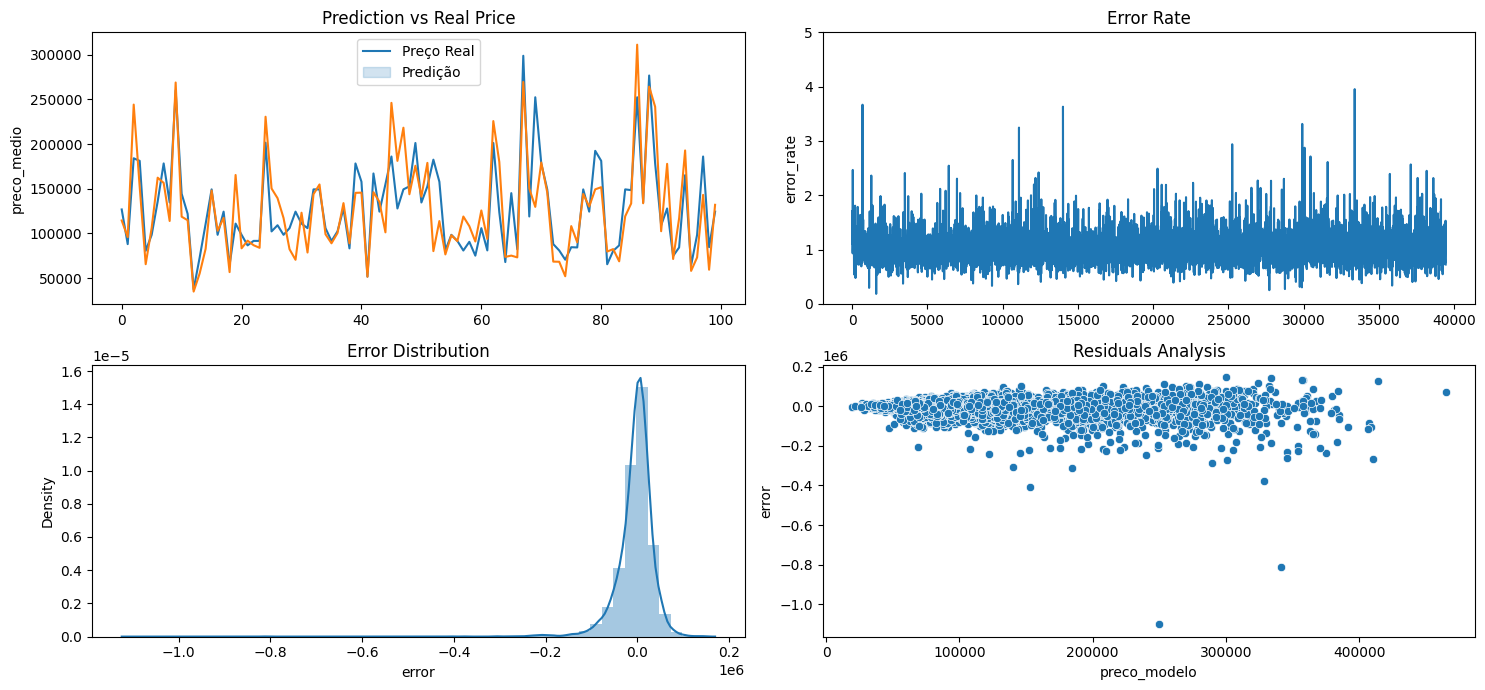

In [111]:
plt.figure(figsize=(15,7))
plt.subplot(2, 2, 1)
plt.title('Prediction vs Real Price')
sns.lineplot(x = range(0,100), y = 'preco_medio', data = data_prod.iloc[0:100])
sns.lineplot(x = range(0,100), y = 'preco_modelo', data = data_prod.iloc[0:100])
plt.legend(['Preço Real', 'Predição'])

plt.subplot(2, 2, 2)
plt.title('Error Rate')
sns.lineplot(x = data_prod.index , y='error_rate', data=data_prod)
plt.ylim(0,5)

plt.subplot(2, 2, 3)
plt.title('Error Distribution')
sns.distplot(data_prod['error'])

plt.subplot(2, 2, 4)
plt.title('Residuals Analysis')
sns.scatterplot(x = 'preco_modelo', y = 'error', data=data_prod)
plt.tight_layout()

# Deploy Model

## Mobility Class

In [134]:
import pickle
import pandas as pd
import numpy as np

class MobilityCars():
    
    def __init__(self):
        self.home_path = 'C:/Users/Notebook/repos/Mobility-Cars/api/'
        self.sc_km_media_ano        = pickle.load(open(self.home_path + 'parameters/sc_km_media_ano.pkl','rb'))
        self.rs_ano_de_fabricacao   = pickle.load(open(self.home_path + 'parameters/rs_ano_de_fabricacao.pkl','rb'))
        self.rs_ano_modelo          = pickle.load(open(self.home_path + 'parameters/rs_ano_modelo.pkl','rb'))
        self.rs_odometro            = pickle.load(open(self.home_path + 'parameters/rs_odometro.pkl','rb'))
        self.oe_tipo_anuncio        = pickle.load(open(self.home_path + 'parameters/oe_tipo_anuncio.pkl', 'rb'))
        self.te_tipo                = pickle.load(open(self.home_path + 'parameters/te_tipo.pkl','rb'))
        self.te_cor                 = pickle.load(open(self.home_path + 'parameters/te_cor.pkl','rb'))
        self.te_localidade_vendedor = pickle.load(open(self.home_path + 'parameters/te_localidade_vendedor.pkl','rb'))
        self.te_valvulas            = pickle.load(open(self.home_path + 'parameters/te_valvulas.pkl','rb'))
        self.te_combustivel         = pickle.load(open(self.home_path + 'parameters/te_combustivel.pkl','rb'))
        self.te_veiculo             = pickle.load(open(self.home_path + 'parameters/te_veiculo.pkl','rb'))
        self.fe_marca               = pickle.load(open(self.home_path + 'parameters/fe_marca.pkl', 'rb'))
        self.fe_modelo              = pickle.load(open(self.home_path + 'parameters/fe_modelo.pkl', 'rb'))
        self.fe_versao              = pickle.load(open(self.home_path + 'parameters/fe_versao.pkl', 'rb'))
        self.fe_cilindradas         = pickle.load(open(self.home_path + 'parameters/fe_cilindradas.pkl', 'rb'))
        
    def deta_cleaning(self, df):
        
        # removendo colunas que possuem NA's + id
        ## Filtering Data
        cols_drop = [
         'ID',
         'num_fotos',
         'attr_veiculo_aceita_troca',
         'attr_veiculo_unico_dono',
         'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
         'attr_veiculo_ipva_pago',
         'attr_veiculo_licenciado',
         'attr_veiculo_garantia_de_fabrica',
         'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
         'attr_veiculo_alienado']

        df = df.drop(columns=cols_drop)
        
        return df
    
    def feature_engineering(self, df4):
        ## Feature Engineering
        # extraindo as cilindradas da coluna versão
        df4['cilindradas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+\.\d+",x)))

        # extraindo válvulas da coluna versão
        df4['valvulas'] = df4['versao'].apply(lambda x: extract_power(re.search(r"\d+V",x)))

        # extraindo combustível da coluna versão
        df4['combustivel'] = df4['versao'].apply(lambda x: 'GASOLINA' if 'GASOLINA' in x else 
                                                           'FLEX' if 'FLEX'     in x else 
                                                           'DIESEL' if 'DIESEL'   in x else 
                                                           'ÁLCOOL' if 'ÁLCOOL' in x else
                                                           'HÍBRIDO' if 'HYBRID' in x else
                                                           'HÍBRIDO' if 'HÍBRIDO' in x else 'sem informação')

        # removendo features derivadas da coluna original
        df4['versao'] = df4.apply(lambda x: x['versao'].replace(x['cilindradas'],'').replace(x['valvulas'], '').replace(x['combustivel'],'').replace(' AUTOMÁTICO', '').replace(' MANUAL', '').replace('  ',' '), axis=1)

        # retirando acentos, substituindo letras maiúsculas e espaços
        df4['cidade_vendedor'] = df4['cidade_vendedor'].apply(lambda x: unidecode(x).lower().replace(' ','_'))

        # extraindo estado
        df4['estado_vendedor'] = df4['estado_vendedor'].apply(lambda x: re.search(r'\((.*?)\)',x).group(1))

        # criando feature de localidade
        df4['localidade_vendedor'] = df4['cidade_vendedor'] + "_" + df4['estado_vendedor']

        # criando feature de km médio rodado por ano
        df4['km_media_ano_em_1k_km'] = df4['odometro']/np.round(2023 - df4['ano_modelo'] + 0.51,0)
        # arredondando e escalando por 1000 km
        df4['km_media_ano_em_1k_km'] = round(df4['km_media_ano_em_1k_km'] / 1000, 0).astype(int)

        # criando feature de agregação do veículo com marca, modelo, km_media e localidade
        df4['veiculo'] = df4['marca'].astype(str) + "_" + df4['modelo'].astype(str) + "_" + df4['km_media_ano_em_1k_km'].astype(str)
        
        return df4

    
    def data_preparation_model(self, df_prep):
        
        ## Standarization
        df_prep['km_media_ano_em_1k_km'] = self.sc_km_media_ano.transform(df_prep[['km_media_ano_em_1k_km']])


        # 6.4  Rescaling
        # 6.4.1  Robust Scaler

        df_prep['ano_de_fabricacao'] = self.rs_ano_de_fabricacao.transform(df_prep[['ano_de_fabricacao']])
        df_prep['ano_modelo'] = self.rs_ano_modelo.transform(df_prep[['ano_modelo']])
        df_prep['odometro'] = self.rs_odometro.transform(df_prep[['odometro']])

        # 6.5  Encodings
        # 6.5.1  One Hot Encode
        # blindado
        df_prep['blindado'] = df_prep['blindado'].replace({'S':1, 'N':0})

        # tipo_vendedor
        df_prep['tipo_vendedor'] = df_prep['tipo_vendedor'].replace({'PJ':1, 'PF':0})

        # tipo_anuncio
        cols_dummies = self.oe_tipo_anuncio.transform(df_prep['tipo_anuncio'].values.reshape(-1,1))
        df_prep[self.oe_tipo_anuncio.categories_[0]] = cols_dummies

        df_prep['cambio'] = df_prep['cambio'].map({'Manual':0,
                                                    'Automática Sequencial':1, 
                                                    'Semi-automática':2,
                                                    'CVT':3,
                                                    'Automatizada':4,
                                                    'Automática':4,
                                                    'Automatizada DCT':5
                                                    })

        df_prep['num_portas'] = df_prep['num_portas'].apply(lambda x: 1 if x > 2 else 0)

        # 6.5.2  Target Enconde
        # ['tipo','cor', 'localidade_vendedor','valvulas','combustivel', 'veiculo']:

        df_prep = self.te_tipo.transform(df_prep)
        df_prep = self.te_cor.transform(df_prep)
        df_prep = self.te_localidade_vendedor.transform(df_prep)
        df_prep = self.te_valvulas.transform(df_prep)
        df_prep = self.te_combustivel.transform(df_prep)
        df_prep = self.te_veiculo.transform(df_prep)


        # 6.5.3  Frequency Encode
        # 'marca', 'modelo','versao','cilindradas'

        df_prep = self.fe_marca.transform(df_prep)
        df_prep = self.fe_modelo.transform(df_prep)
        df_prep = self.fe_versao.transform(df_prep)        
        df_prep = self.fe_cilindradas.transform(df_prep)
        
        features_selected = [
        'veiculo',
        'marca',
        'km_media_ano_em_1k_km',
        'modelo',
        'versao',
        'ano_de_fabricacao',
        'ano_modelo',
        'odometro',
        'cambio',
        'tipo',
        'cilindradas',
        'combustivel',
        'localidade_vendedor'
        ]
        
        return df_prep[features_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        pred = model.predict(test_data)
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', data_format = 'iso')

## API Handler

In [137]:
from flask import Flask, request, Response
import pickle
import pandas as pd
# from mobility import MobilityCars

model = pickle.load(open('api/model/model_xgb.pkl', 'rb'))

app = Flask(__name__)

@app.route('/C:/Users/Notebook/repos/Mobility-Cars/mobility/predict', methods = ['POST'])
def mobility_preditc():
    test_json = request.get_json()
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        ## Instantiate
        pipeline = MobilityCars()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation_model(df2)

        # predict
        df_response = pipeline.get_prediction( model, test_raw, df3)

        return df_response
    else:
            return Response('{}', status=200, mimutype = 'application/json')
                    
if __name__ == '__main__':
    app.run('192.168.18.4')

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.18.4:5000
Press CTRL+C to quit


## API Tester

## Final Table

In [111]:
df_test = pd.read_csv('datasets/teste.csv')
df_test.columns = [unidecode(col).lower().replace(' ','_') for col in df_test.columns]

In [112]:
# request of all test data
# url = 'https://mobility-cars.onrender.com/mobility/predict'
url = 'http://192.168.18.4:5000/mobility/predict'
header = {'Content-type':'application/json'}
data = json.dumps(df_test.to_dict(orient='records'))

r = requests.post(url, data = data, headers = header)
print('Status Code: {}'.format(r.status_code))

# transform in DataFrame
test_predicts_raw = pd.DataFrame(r.json())

Status Code: 200


In [116]:
df_test = feature_engineering(df_test)

In [117]:
df_test['preco sugerido'] = test_predicts_raw['prediction']

In [119]:
df_test.to_csv('Tabela de Preços.csv', index=False)